So we know from Notebook 10 that trying to make it learn one set of logits per batch is good and gets features right.

How can we make the logits consistent over batches?

Will collect the gradients and gumbel selected values after 5 epochs in each mode. The two modes will be the behavior before burn-in and the behavior after mode-in.

Will follow Notebook 10 with slight modifications (described right before). Remember in Notebook 10, we explored behaviors when all the features were real vs when half the features were noise.

In [1]:
import torch


from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F

import numpy as np

import matplotlib.pyplot as plt
#from sklearn.manifold import TSNE

#import math

#import gc

from utils import *

from sklearn.preprocessing import MinMaxScaler

from scipy.stats import pearsonr

import seaborn as sns

In [2]:
torch.manual_seed(0)
np.random.seed(0)

In [3]:
# really good results for vanilla VAE on synthetic data with EPOCHS set to 50, 
# but when running locally set to 10 for reasonable run times
n_epochs = 600
batch_size = 64
lr = 0.0001
b1 = 0.9
b2 = 0.999

In [4]:
cuda = True if torch.cuda.is_available() else False

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

device = torch.device("cuda:0" if cuda else "cpu")
#device = 'cpu'
print("Device")
print(device)

Device
cuda:0


In [5]:
D = 30
N = 10000
z_size = 8

In [6]:
torch.manual_seed(0)
np.random.seed(0)

latent_data = np.random.normal(loc=0.0, scale=1.0, size=N*z_size).reshape(N, z_size)

data_mapper = nn.Sequential(
    nn.Linear(z_size, 2 * z_size, bias=False),
    nn.Tanh(),
    nn.Linear(2 * z_size, D, bias = True),
    nn.ReLU()
).to(device)

data_mapper.requires_grad_(False)

latent_data = Tensor(latent_data)
latent_data.requires_grad_(False)

actual_data = data_mapper(latent_data)


for i in range(5):
    print(torch.sum(actual_data[i,:] != 0))

tensor(14, device='cuda:0')
tensor(18, device='cuda:0')
tensor(14, device='cuda:0')
tensor(17, device='cuda:0')
tensor(16, device='cuda:0')


add noiise

In [7]:
noise_features = torch.empty(N * D).normal_(mean=0,std=0.01).reshape(N, D).to(device)
noise_features.requires_grad_(False)

tensor([[ 0.0013,  0.0135,  0.0054,  ..., -0.0047,  0.0033, -0.0097],
        [ 0.0080, -0.0057,  0.0010,  ...,  0.0009, -0.0134,  0.0105],
        [-0.0103, -0.0029,  0.0185,  ..., -0.0133, -0.0037,  0.0134],
        ...,
        [ 0.0073, -0.0149, -0.0108,  ..., -0.0047, -0.0137,  0.0070],
        [ 0.0006, -0.0141, -0.0124,  ..., -0.0085,  0.0069, -0.0110],
        [-0.0159,  0.0177, -0.0087,  ..., -0.0076, -0.0009,  0.0078]],
       device='cuda:0')

In [8]:
actual_data = torch.cat([actual_data, noise_features], dim = 1)

In [9]:
actual_data.shape

torch.Size([10000, 60])

In [10]:
actual_data = actual_data.cpu().numpy()
scaler = MinMaxScaler()
actual_data = scaler.fit_transform(actual_data)

actual_data = Tensor(actual_data)

slices = np.random.permutation(np.arange(actual_data.shape[0]))
upto = int(.8 * len(actual_data))

train_data = actual_data[slices[:upto]]
test_data = actual_data[slices[upto:]]

In [11]:
global_t = 4

Example of what worked before
Vanilla Gumbel

In [12]:
vae_gumbel_truncated = VAE_Gumbel(2*D, 100, 20, k = 3*z_size, t = global_t)
vae_gumbel_truncated.to(device)
vae_gumbel_trunc_optimizer = torch.optim.Adam(vae_gumbel_truncated.parameters(), 
                                                lr=lr, 
                                                betas = (b1,b2))

In [13]:
gradients_before_burnin = torch.zeros(train_data.shape[1]).to(device)
gradient_post_burn_in = torch.zeros(train_data.shape[1]).to(device)
subset_indices_before_burnin = torch.zeros(train_data.shape[1]).to(device)
subset_indices_post_burnin = torch.zeros(train_data.shape[1]).to(device)

for epoch in range(1, n_epochs+1):
    grads=train_truncated_with_gradients(train_data, vae_gumbel_truncated, 
                                                      vae_gumbel_trunc_optimizer, 
                                                      epoch, 
                                                      batch_size, 
                                                      Dim = 2*D)
    
    vae_gumbel_truncated.t = max(0.001, vae_gumbel_truncated.t * 0.99)
    if epoch <=(n_epochs//5*4):
        gradients_before_burnin += grads
        with torch.no_grad():
            subset_indices_before_burnin += vae_gumbel_truncated.subset_indices.mean(dim = 0)
    if epoch > (n_epochs//5*4):
        gradient_post_burn_in += grads
        with torch.no_grad():
            subset_indices_post_burnin += vae_gumbel_truncated.subset_indices.mean(dim = 0)

Train Epoch: 1 [0/8000 (0%)]	Loss: 42.025238
Train Epoch: 1 [1280/8000 (16%)]	Loss: 41.364944
Train Epoch: 1 [2560/8000 (32%)]	Loss: 40.814362
Train Epoch: 1 [3840/8000 (48%)]	Loss: 40.379112
Train Epoch: 1 [5120/8000 (64%)]	Loss: 39.789692
Train Epoch: 1 [6400/8000 (80%)]	Loss: 39.276009
Train Epoch: 1 [7680/8000 (96%)]	Loss: 38.740120
====> Epoch: 1 Average loss: 40.2651
Train Epoch: 2 [0/8000 (0%)]	Loss: 38.672573
Train Epoch: 2 [1280/8000 (16%)]	Loss: 37.857533
Train Epoch: 2 [2560/8000 (32%)]	Loss: 37.325977
Train Epoch: 2 [3840/8000 (48%)]	Loss: 36.101463
Train Epoch: 2 [5120/8000 (64%)]	Loss: 35.596703
Train Epoch: 2 [6400/8000 (80%)]	Loss: 34.989117
Train Epoch: 2 [7680/8000 (96%)]	Loss: 34.360310
====> Epoch: 2 Average loss: 36.4149
Train Epoch: 3 [0/8000 (0%)]	Loss: 34.523701
Train Epoch: 3 [1280/8000 (16%)]	Loss: 34.206936
Train Epoch: 3 [2560/8000 (32%)]	Loss: 33.856945
Train Epoch: 3 [3840/8000 (48%)]	Loss: 33.793369
Train Epoch: 3 [5120/8000 (64%)]	Loss: 33.988956
Train E

Train Epoch: 22 [6400/8000 (80%)]	Loss: 31.013247
Train Epoch: 22 [7680/8000 (96%)]	Loss: 31.270163
====> Epoch: 22 Average loss: 31.2534
Train Epoch: 23 [0/8000 (0%)]	Loss: 31.400995
Train Epoch: 23 [1280/8000 (16%)]	Loss: 31.041733
Train Epoch: 23 [2560/8000 (32%)]	Loss: 31.345234
Train Epoch: 23 [3840/8000 (48%)]	Loss: 31.320532
Train Epoch: 23 [5120/8000 (64%)]	Loss: 31.026028
Train Epoch: 23 [6400/8000 (80%)]	Loss: 31.138870
Train Epoch: 23 [7680/8000 (96%)]	Loss: 31.540070
====> Epoch: 23 Average loss: 31.1998
Train Epoch: 24 [0/8000 (0%)]	Loss: 31.346783
Train Epoch: 24 [1280/8000 (16%)]	Loss: 31.366404
Train Epoch: 24 [2560/8000 (32%)]	Loss: 31.085634
Train Epoch: 24 [3840/8000 (48%)]	Loss: 31.071608
Train Epoch: 24 [5120/8000 (64%)]	Loss: 31.239252
Train Epoch: 24 [6400/8000 (80%)]	Loss: 30.930275
Train Epoch: 24 [7680/8000 (96%)]	Loss: 30.941076
====> Epoch: 24 Average loss: 31.1411
Train Epoch: 25 [0/8000 (0%)]	Loss: 31.086084
Train Epoch: 25 [1280/8000 (16%)]	Loss: 31.14980

Train Epoch: 44 [1280/8000 (16%)]	Loss: 30.670044
Train Epoch: 44 [2560/8000 (32%)]	Loss: 30.412287
Train Epoch: 44 [3840/8000 (48%)]	Loss: 30.284142
Train Epoch: 44 [5120/8000 (64%)]	Loss: 30.688267
Train Epoch: 44 [6400/8000 (80%)]	Loss: 30.450047
Train Epoch: 44 [7680/8000 (96%)]	Loss: 30.535494
====> Epoch: 44 Average loss: 30.5022
Train Epoch: 45 [0/8000 (0%)]	Loss: 30.533203
Train Epoch: 45 [1280/8000 (16%)]	Loss: 30.846596
Train Epoch: 45 [2560/8000 (32%)]	Loss: 30.508860
Train Epoch: 45 [3840/8000 (48%)]	Loss: 29.904802
Train Epoch: 45 [5120/8000 (64%)]	Loss: 30.310843
Train Epoch: 45 [6400/8000 (80%)]	Loss: 30.303701
Train Epoch: 45 [7680/8000 (96%)]	Loss: 30.523859
====> Epoch: 45 Average loss: 30.4841
Train Epoch: 46 [0/8000 (0%)]	Loss: 30.400795
Train Epoch: 46 [1280/8000 (16%)]	Loss: 30.438272
Train Epoch: 46 [2560/8000 (32%)]	Loss: 30.436558
Train Epoch: 46 [3840/8000 (48%)]	Loss: 30.414251
Train Epoch: 46 [5120/8000 (64%)]	Loss: 30.590418
Train Epoch: 46 [6400/8000 (80%)

Train Epoch: 65 [5120/8000 (64%)]	Loss: 30.314861
Train Epoch: 65 [6400/8000 (80%)]	Loss: 30.275429
Train Epoch: 65 [7680/8000 (96%)]	Loss: 30.515646
====> Epoch: 65 Average loss: 30.2654
Train Epoch: 66 [0/8000 (0%)]	Loss: 30.269190
Train Epoch: 66 [1280/8000 (16%)]	Loss: 30.405798
Train Epoch: 66 [2560/8000 (32%)]	Loss: 30.376183
Train Epoch: 66 [3840/8000 (48%)]	Loss: 30.321278
Train Epoch: 66 [5120/8000 (64%)]	Loss: 30.236647
Train Epoch: 66 [6400/8000 (80%)]	Loss: 30.661760
Train Epoch: 66 [7680/8000 (96%)]	Loss: 30.284760
====> Epoch: 66 Average loss: 30.2637
Train Epoch: 67 [0/8000 (0%)]	Loss: 30.550797
Train Epoch: 67 [1280/8000 (16%)]	Loss: 30.160597
Train Epoch: 67 [2560/8000 (32%)]	Loss: 30.037903
Train Epoch: 67 [3840/8000 (48%)]	Loss: 30.047459
Train Epoch: 67 [5120/8000 (64%)]	Loss: 29.959616
Train Epoch: 67 [6400/8000 (80%)]	Loss: 30.219284
Train Epoch: 67 [7680/8000 (96%)]	Loss: 30.353281
====> Epoch: 67 Average loss: 30.2571
Train Epoch: 68 [0/8000 (0%)]	Loss: 30.20444

Train Epoch: 87 [1280/8000 (16%)]	Loss: 30.178322
Train Epoch: 87 [2560/8000 (32%)]	Loss: 30.091436
Train Epoch: 87 [3840/8000 (48%)]	Loss: 30.255022
Train Epoch: 87 [5120/8000 (64%)]	Loss: 30.174248
Train Epoch: 87 [6400/8000 (80%)]	Loss: 30.241972
Train Epoch: 87 [7680/8000 (96%)]	Loss: 29.892473
====> Epoch: 87 Average loss: 30.1181
Train Epoch: 88 [0/8000 (0%)]	Loss: 29.949902
Train Epoch: 88 [1280/8000 (16%)]	Loss: 30.106182
Train Epoch: 88 [2560/8000 (32%)]	Loss: 30.103258
Train Epoch: 88 [3840/8000 (48%)]	Loss: 29.951073
Train Epoch: 88 [5120/8000 (64%)]	Loss: 30.088888
Train Epoch: 88 [6400/8000 (80%)]	Loss: 29.955593
Train Epoch: 88 [7680/8000 (96%)]	Loss: 29.905472
====> Epoch: 88 Average loss: 30.1153
Train Epoch: 89 [0/8000 (0%)]	Loss: 30.026413
Train Epoch: 89 [1280/8000 (16%)]	Loss: 30.342913
Train Epoch: 89 [2560/8000 (32%)]	Loss: 30.477049
Train Epoch: 89 [3840/8000 (48%)]	Loss: 29.976637
Train Epoch: 89 [5120/8000 (64%)]	Loss: 30.036428
Train Epoch: 89 [6400/8000 (80%)

Train Epoch: 108 [3840/8000 (48%)]	Loss: 30.187504
Train Epoch: 108 [5120/8000 (64%)]	Loss: 30.084991
Train Epoch: 108 [6400/8000 (80%)]	Loss: 29.825407
Train Epoch: 108 [7680/8000 (96%)]	Loss: 30.185699
====> Epoch: 108 Average loss: 30.0199
Train Epoch: 109 [0/8000 (0%)]	Loss: 30.047487
Train Epoch: 109 [1280/8000 (16%)]	Loss: 30.071058
Train Epoch: 109 [2560/8000 (32%)]	Loss: 30.151487
Train Epoch: 109 [3840/8000 (48%)]	Loss: 29.893038
Train Epoch: 109 [5120/8000 (64%)]	Loss: 30.048811
Train Epoch: 109 [6400/8000 (80%)]	Loss: 30.199945
Train Epoch: 109 [7680/8000 (96%)]	Loss: 29.811132
====> Epoch: 109 Average loss: 30.0074
Train Epoch: 110 [0/8000 (0%)]	Loss: 30.155910
Train Epoch: 110 [1280/8000 (16%)]	Loss: 29.979328
Train Epoch: 110 [2560/8000 (32%)]	Loss: 29.907679
Train Epoch: 110 [3840/8000 (48%)]	Loss: 30.225660
Train Epoch: 110 [5120/8000 (64%)]	Loss: 29.976118
Train Epoch: 110 [6400/8000 (80%)]	Loss: 30.185572
Train Epoch: 110 [7680/8000 (96%)]	Loss: 30.027384
====> Epoch:

Train Epoch: 129 [3840/8000 (48%)]	Loss: 29.985014
Train Epoch: 129 [5120/8000 (64%)]	Loss: 29.919464
Train Epoch: 129 [6400/8000 (80%)]	Loss: 30.219847
Train Epoch: 129 [7680/8000 (96%)]	Loss: 29.820976
====> Epoch: 129 Average loss: 29.9723
Train Epoch: 130 [0/8000 (0%)]	Loss: 30.122189
Train Epoch: 130 [1280/8000 (16%)]	Loss: 30.201637
Train Epoch: 130 [2560/8000 (32%)]	Loss: 29.909433
Train Epoch: 130 [3840/8000 (48%)]	Loss: 30.099302
Train Epoch: 130 [5120/8000 (64%)]	Loss: 30.374634
Train Epoch: 130 [6400/8000 (80%)]	Loss: 29.855406
Train Epoch: 130 [7680/8000 (96%)]	Loss: 30.114468
====> Epoch: 130 Average loss: 29.9691
Train Epoch: 131 [0/8000 (0%)]	Loss: 30.045776
Train Epoch: 131 [1280/8000 (16%)]	Loss: 29.958166
Train Epoch: 131 [2560/8000 (32%)]	Loss: 29.941027
Train Epoch: 131 [3840/8000 (48%)]	Loss: 29.994801
Train Epoch: 131 [5120/8000 (64%)]	Loss: 29.670864
Train Epoch: 131 [6400/8000 (80%)]	Loss: 30.106087
Train Epoch: 131 [7680/8000 (96%)]	Loss: 30.091990
====> Epoch:

Train Epoch: 150 [3840/8000 (48%)]	Loss: 29.749752
Train Epoch: 150 [5120/8000 (64%)]	Loss: 29.954885
Train Epoch: 150 [6400/8000 (80%)]	Loss: 30.014194
Train Epoch: 150 [7680/8000 (96%)]	Loss: 29.903946
====> Epoch: 150 Average loss: 29.9383
Train Epoch: 151 [0/8000 (0%)]	Loss: 29.989189
Train Epoch: 151 [1280/8000 (16%)]	Loss: 29.882895
Train Epoch: 151 [2560/8000 (32%)]	Loss: 30.154171
Train Epoch: 151 [3840/8000 (48%)]	Loss: 30.058058
Train Epoch: 151 [5120/8000 (64%)]	Loss: 29.770472
Train Epoch: 151 [6400/8000 (80%)]	Loss: 30.269991
Train Epoch: 151 [7680/8000 (96%)]	Loss: 29.704365
====> Epoch: 151 Average loss: 29.9426
Train Epoch: 152 [0/8000 (0%)]	Loss: 29.933056
Train Epoch: 152 [1280/8000 (16%)]	Loss: 30.089949
Train Epoch: 152 [2560/8000 (32%)]	Loss: 30.051254
Train Epoch: 152 [3840/8000 (48%)]	Loss: 29.807831
Train Epoch: 152 [5120/8000 (64%)]	Loss: 29.812853
Train Epoch: 152 [6400/8000 (80%)]	Loss: 29.733080
Train Epoch: 152 [7680/8000 (96%)]	Loss: 29.984697
====> Epoch:

Train Epoch: 171 [3840/8000 (48%)]	Loss: 29.825205
Train Epoch: 171 [5120/8000 (64%)]	Loss: 29.897509
Train Epoch: 171 [6400/8000 (80%)]	Loss: 29.795473
Train Epoch: 171 [7680/8000 (96%)]	Loss: 29.633804
====> Epoch: 171 Average loss: 29.9267
Train Epoch: 172 [0/8000 (0%)]	Loss: 30.154598
Train Epoch: 172 [1280/8000 (16%)]	Loss: 29.911493
Train Epoch: 172 [2560/8000 (32%)]	Loss: 30.012550
Train Epoch: 172 [3840/8000 (48%)]	Loss: 29.933237
Train Epoch: 172 [5120/8000 (64%)]	Loss: 29.937500
Train Epoch: 172 [6400/8000 (80%)]	Loss: 29.816090
Train Epoch: 172 [7680/8000 (96%)]	Loss: 29.972908
====> Epoch: 172 Average loss: 29.9230
Train Epoch: 173 [0/8000 (0%)]	Loss: 29.951574
Train Epoch: 173 [1280/8000 (16%)]	Loss: 30.172197
Train Epoch: 173 [2560/8000 (32%)]	Loss: 29.894226
Train Epoch: 173 [3840/8000 (48%)]	Loss: 30.058176
Train Epoch: 173 [5120/8000 (64%)]	Loss: 30.124512
Train Epoch: 173 [6400/8000 (80%)]	Loss: 29.841183
Train Epoch: 173 [7680/8000 (96%)]	Loss: 29.712990
====> Epoch:

Train Epoch: 192 [3840/8000 (48%)]	Loss: 30.222816
Train Epoch: 192 [5120/8000 (64%)]	Loss: 30.060699
Train Epoch: 192 [6400/8000 (80%)]	Loss: 30.104168
Train Epoch: 192 [7680/8000 (96%)]	Loss: 29.902025
====> Epoch: 192 Average loss: 29.9089
Train Epoch: 193 [0/8000 (0%)]	Loss: 29.930532
Train Epoch: 193 [1280/8000 (16%)]	Loss: 29.928764
Train Epoch: 193 [2560/8000 (32%)]	Loss: 29.963558
Train Epoch: 193 [3840/8000 (48%)]	Loss: 30.271313
Train Epoch: 193 [5120/8000 (64%)]	Loss: 29.973206
Train Epoch: 193 [6400/8000 (80%)]	Loss: 29.941650
Train Epoch: 193 [7680/8000 (96%)]	Loss: 29.890982
====> Epoch: 193 Average loss: 29.9097
Train Epoch: 194 [0/8000 (0%)]	Loss: 30.111902
Train Epoch: 194 [1280/8000 (16%)]	Loss: 29.820795
Train Epoch: 194 [2560/8000 (32%)]	Loss: 29.893639
Train Epoch: 194 [3840/8000 (48%)]	Loss: 29.748861
Train Epoch: 194 [5120/8000 (64%)]	Loss: 29.962934
Train Epoch: 194 [6400/8000 (80%)]	Loss: 30.054029
Train Epoch: 194 [7680/8000 (96%)]	Loss: 30.138664
====> Epoch:

Train Epoch: 213 [3840/8000 (48%)]	Loss: 30.119467
Train Epoch: 213 [5120/8000 (64%)]	Loss: 29.941584
Train Epoch: 213 [6400/8000 (80%)]	Loss: 29.797318
Train Epoch: 213 [7680/8000 (96%)]	Loss: 29.949215
====> Epoch: 213 Average loss: 29.8991
Train Epoch: 214 [0/8000 (0%)]	Loss: 29.839544
Train Epoch: 214 [1280/8000 (16%)]	Loss: 29.883739
Train Epoch: 214 [2560/8000 (32%)]	Loss: 29.887419
Train Epoch: 214 [3840/8000 (48%)]	Loss: 29.690292
Train Epoch: 214 [5120/8000 (64%)]	Loss: 30.246571
Train Epoch: 214 [6400/8000 (80%)]	Loss: 29.978983
Train Epoch: 214 [7680/8000 (96%)]	Loss: 29.981712
====> Epoch: 214 Average loss: 29.9021
Train Epoch: 215 [0/8000 (0%)]	Loss: 29.795774
Train Epoch: 215 [1280/8000 (16%)]	Loss: 30.158306
Train Epoch: 215 [2560/8000 (32%)]	Loss: 29.867483
Train Epoch: 215 [3840/8000 (48%)]	Loss: 29.992905
Train Epoch: 215 [5120/8000 (64%)]	Loss: 29.758713
Train Epoch: 215 [6400/8000 (80%)]	Loss: 30.128817
Train Epoch: 215 [7680/8000 (96%)]	Loss: 29.955023
====> Epoch:

Train Epoch: 234 [3840/8000 (48%)]	Loss: 30.038889
Train Epoch: 234 [5120/8000 (64%)]	Loss: 29.957014
Train Epoch: 234 [6400/8000 (80%)]	Loss: 29.933414
Train Epoch: 234 [7680/8000 (96%)]	Loss: 29.695461
====> Epoch: 234 Average loss: 29.8886
Train Epoch: 235 [0/8000 (0%)]	Loss: 29.780043
Train Epoch: 235 [1280/8000 (16%)]	Loss: 30.145016
Train Epoch: 235 [2560/8000 (32%)]	Loss: 29.855495
Train Epoch: 235 [3840/8000 (48%)]	Loss: 29.794701
Train Epoch: 235 [5120/8000 (64%)]	Loss: 29.772831
Train Epoch: 235 [6400/8000 (80%)]	Loss: 29.978886
Train Epoch: 235 [7680/8000 (96%)]	Loss: 29.753181
====> Epoch: 235 Average loss: 29.8867
Train Epoch: 236 [0/8000 (0%)]	Loss: 29.773815
Train Epoch: 236 [1280/8000 (16%)]	Loss: 29.933281
Train Epoch: 236 [2560/8000 (32%)]	Loss: 29.645767
Train Epoch: 236 [3840/8000 (48%)]	Loss: 29.926254
Train Epoch: 236 [5120/8000 (64%)]	Loss: 29.930956
Train Epoch: 236 [6400/8000 (80%)]	Loss: 29.873896
Train Epoch: 236 [7680/8000 (96%)]	Loss: 30.033524
====> Epoch:

Train Epoch: 255 [3840/8000 (48%)]	Loss: 29.914280
Train Epoch: 255 [5120/8000 (64%)]	Loss: 29.604420
Train Epoch: 255 [6400/8000 (80%)]	Loss: 30.064692
Train Epoch: 255 [7680/8000 (96%)]	Loss: 29.801399
====> Epoch: 255 Average loss: 29.8879
Train Epoch: 256 [0/8000 (0%)]	Loss: 30.018766
Train Epoch: 256 [1280/8000 (16%)]	Loss: 29.783800
Train Epoch: 256 [2560/8000 (32%)]	Loss: 29.791483
Train Epoch: 256 [3840/8000 (48%)]	Loss: 29.889681
Train Epoch: 256 [5120/8000 (64%)]	Loss: 29.727346
Train Epoch: 256 [6400/8000 (80%)]	Loss: 29.899672
Train Epoch: 256 [7680/8000 (96%)]	Loss: 29.867802
====> Epoch: 256 Average loss: 29.8831
Train Epoch: 257 [0/8000 (0%)]	Loss: 29.792427
Train Epoch: 257 [1280/8000 (16%)]	Loss: 30.205387
Train Epoch: 257 [2560/8000 (32%)]	Loss: 29.972410
Train Epoch: 257 [3840/8000 (48%)]	Loss: 29.745226
Train Epoch: 257 [5120/8000 (64%)]	Loss: 29.816378
Train Epoch: 257 [6400/8000 (80%)]	Loss: 30.031929
Train Epoch: 257 [7680/8000 (96%)]	Loss: 29.761208
====> Epoch:

Train Epoch: 276 [3840/8000 (48%)]	Loss: 29.628841
Train Epoch: 276 [5120/8000 (64%)]	Loss: 30.032913
Train Epoch: 276 [6400/8000 (80%)]	Loss: 29.950617
Train Epoch: 276 [7680/8000 (96%)]	Loss: 29.897568
====> Epoch: 276 Average loss: 29.8897
Train Epoch: 277 [0/8000 (0%)]	Loss: 30.019409
Train Epoch: 277 [1280/8000 (16%)]	Loss: 29.637428
Train Epoch: 277 [2560/8000 (32%)]	Loss: 29.856844
Train Epoch: 277 [3840/8000 (48%)]	Loss: 29.778315
Train Epoch: 277 [5120/8000 (64%)]	Loss: 29.973459
Train Epoch: 277 [6400/8000 (80%)]	Loss: 29.765484
Train Epoch: 277 [7680/8000 (96%)]	Loss: 30.126080
====> Epoch: 277 Average loss: 29.8865
Train Epoch: 278 [0/8000 (0%)]	Loss: 29.856239
Train Epoch: 278 [1280/8000 (16%)]	Loss: 30.042213
Train Epoch: 278 [2560/8000 (32%)]	Loss: 29.932316
Train Epoch: 278 [3840/8000 (48%)]	Loss: 29.884962
Train Epoch: 278 [5120/8000 (64%)]	Loss: 29.660421
Train Epoch: 278 [6400/8000 (80%)]	Loss: 30.074553
Train Epoch: 278 [7680/8000 (96%)]	Loss: 30.105274
====> Epoch:

Train Epoch: 297 [3840/8000 (48%)]	Loss: 29.617807
Train Epoch: 297 [5120/8000 (64%)]	Loss: 29.947329
Train Epoch: 297 [6400/8000 (80%)]	Loss: 29.799597
Train Epoch: 297 [7680/8000 (96%)]	Loss: 29.685078
====> Epoch: 297 Average loss: 29.8841
Train Epoch: 298 [0/8000 (0%)]	Loss: 30.049799
Train Epoch: 298 [1280/8000 (16%)]	Loss: 29.784077
Train Epoch: 298 [2560/8000 (32%)]	Loss: 29.923767
Train Epoch: 298 [3840/8000 (48%)]	Loss: 29.788635
Train Epoch: 298 [5120/8000 (64%)]	Loss: 29.831011
Train Epoch: 298 [6400/8000 (80%)]	Loss: 29.843224
Train Epoch: 298 [7680/8000 (96%)]	Loss: 29.931044
====> Epoch: 298 Average loss: 29.8960
Train Epoch: 299 [0/8000 (0%)]	Loss: 29.784607
Train Epoch: 299 [1280/8000 (16%)]	Loss: 30.015869
Train Epoch: 299 [2560/8000 (32%)]	Loss: 30.110130
Train Epoch: 299 [3840/8000 (48%)]	Loss: 30.118687
Train Epoch: 299 [5120/8000 (64%)]	Loss: 29.648788
Train Epoch: 299 [6400/8000 (80%)]	Loss: 29.750799
Train Epoch: 299 [7680/8000 (96%)]	Loss: 29.804449
====> Epoch:

Train Epoch: 318 [3840/8000 (48%)]	Loss: 29.749100
Train Epoch: 318 [5120/8000 (64%)]	Loss: 30.035702
Train Epoch: 318 [6400/8000 (80%)]	Loss: 29.961561
Train Epoch: 318 [7680/8000 (96%)]	Loss: 29.569353
====> Epoch: 318 Average loss: 29.8831
Train Epoch: 319 [0/8000 (0%)]	Loss: 29.704031
Train Epoch: 319 [1280/8000 (16%)]	Loss: 29.798531
Train Epoch: 319 [2560/8000 (32%)]	Loss: 29.845575
Train Epoch: 319 [3840/8000 (48%)]	Loss: 29.872572
Train Epoch: 319 [5120/8000 (64%)]	Loss: 29.871683
Train Epoch: 319 [6400/8000 (80%)]	Loss: 30.076948
Train Epoch: 319 [7680/8000 (96%)]	Loss: 30.090963
====> Epoch: 319 Average loss: 29.8862
Train Epoch: 320 [0/8000 (0%)]	Loss: 29.693029
Train Epoch: 320 [1280/8000 (16%)]	Loss: 29.920881
Train Epoch: 320 [2560/8000 (32%)]	Loss: 29.895258
Train Epoch: 320 [3840/8000 (48%)]	Loss: 29.647491
Train Epoch: 320 [5120/8000 (64%)]	Loss: 29.681486
Train Epoch: 320 [6400/8000 (80%)]	Loss: 30.012787
Train Epoch: 320 [7680/8000 (96%)]	Loss: 30.116014
====> Epoch:

Train Epoch: 339 [3840/8000 (48%)]	Loss: 29.633453
Train Epoch: 339 [5120/8000 (64%)]	Loss: 29.920126
Train Epoch: 339 [6400/8000 (80%)]	Loss: 29.743887
Train Epoch: 339 [7680/8000 (96%)]	Loss: 30.091244
====> Epoch: 339 Average loss: 29.8819
Train Epoch: 340 [0/8000 (0%)]	Loss: 29.931381
Train Epoch: 340 [1280/8000 (16%)]	Loss: 29.813457
Train Epoch: 340 [2560/8000 (32%)]	Loss: 29.803770
Train Epoch: 340 [3840/8000 (48%)]	Loss: 29.894396
Train Epoch: 340 [5120/8000 (64%)]	Loss: 29.930799
Train Epoch: 340 [6400/8000 (80%)]	Loss: 29.988342
Train Epoch: 340 [7680/8000 (96%)]	Loss: 29.821905
====> Epoch: 340 Average loss: 29.8854
Train Epoch: 341 [0/8000 (0%)]	Loss: 30.001682
Train Epoch: 341 [1280/8000 (16%)]	Loss: 29.808956
Train Epoch: 341 [2560/8000 (32%)]	Loss: 29.972176
Train Epoch: 341 [3840/8000 (48%)]	Loss: 30.125950
Train Epoch: 341 [5120/8000 (64%)]	Loss: 29.749815
Train Epoch: 341 [6400/8000 (80%)]	Loss: 29.792273
Train Epoch: 341 [7680/8000 (96%)]	Loss: 29.971445
====> Epoch:

Train Epoch: 360 [3840/8000 (48%)]	Loss: 30.015242
Train Epoch: 360 [5120/8000 (64%)]	Loss: 29.979177
Train Epoch: 360 [6400/8000 (80%)]	Loss: 30.068678
Train Epoch: 360 [7680/8000 (96%)]	Loss: 29.693998
====> Epoch: 360 Average loss: 29.8886
Train Epoch: 361 [0/8000 (0%)]	Loss: 30.072481
Train Epoch: 361 [1280/8000 (16%)]	Loss: 29.890997
Train Epoch: 361 [2560/8000 (32%)]	Loss: 29.510504
Train Epoch: 361 [3840/8000 (48%)]	Loss: 29.779207
Train Epoch: 361 [5120/8000 (64%)]	Loss: 29.899338
Train Epoch: 361 [6400/8000 (80%)]	Loss: 29.576227
Train Epoch: 361 [7680/8000 (96%)]	Loss: 29.996140
====> Epoch: 361 Average loss: 29.8823
Train Epoch: 362 [0/8000 (0%)]	Loss: 29.994949
Train Epoch: 362 [1280/8000 (16%)]	Loss: 29.940674
Train Epoch: 362 [2560/8000 (32%)]	Loss: 29.892300
Train Epoch: 362 [3840/8000 (48%)]	Loss: 29.955666
Train Epoch: 362 [5120/8000 (64%)]	Loss: 29.678120
Train Epoch: 362 [6400/8000 (80%)]	Loss: 30.019081
Train Epoch: 362 [7680/8000 (96%)]	Loss: 29.933397
====> Epoch:

Train Epoch: 381 [3840/8000 (48%)]	Loss: 29.971119
Train Epoch: 381 [5120/8000 (64%)]	Loss: 29.741529
Train Epoch: 381 [6400/8000 (80%)]	Loss: 30.033043
Train Epoch: 381 [7680/8000 (96%)]	Loss: 29.689795
====> Epoch: 381 Average loss: 29.8818
Train Epoch: 382 [0/8000 (0%)]	Loss: 29.957310
Train Epoch: 382 [1280/8000 (16%)]	Loss: 29.892405
Train Epoch: 382 [2560/8000 (32%)]	Loss: 29.728783
Train Epoch: 382 [3840/8000 (48%)]	Loss: 29.906771
Train Epoch: 382 [5120/8000 (64%)]	Loss: 29.694315
Train Epoch: 382 [6400/8000 (80%)]	Loss: 29.846998
Train Epoch: 382 [7680/8000 (96%)]	Loss: 29.858217
====> Epoch: 382 Average loss: 29.8813
Train Epoch: 383 [0/8000 (0%)]	Loss: 29.901493
Train Epoch: 383 [1280/8000 (16%)]	Loss: 29.741205
Train Epoch: 383 [2560/8000 (32%)]	Loss: 30.037868
Train Epoch: 383 [3840/8000 (48%)]	Loss: 29.870022
Train Epoch: 383 [5120/8000 (64%)]	Loss: 29.830746
Train Epoch: 383 [6400/8000 (80%)]	Loss: 30.024740
Train Epoch: 383 [7680/8000 (96%)]	Loss: 29.799429
====> Epoch:

Train Epoch: 402 [3840/8000 (48%)]	Loss: 30.138117
Train Epoch: 402 [5120/8000 (64%)]	Loss: 30.035879
Train Epoch: 402 [6400/8000 (80%)]	Loss: 30.024965
Train Epoch: 402 [7680/8000 (96%)]	Loss: 30.232817
====> Epoch: 402 Average loss: 29.8806
Train Epoch: 403 [0/8000 (0%)]	Loss: 29.568306
Train Epoch: 403 [1280/8000 (16%)]	Loss: 29.724127
Train Epoch: 403 [2560/8000 (32%)]	Loss: 30.048752
Train Epoch: 403 [3840/8000 (48%)]	Loss: 29.594883
Train Epoch: 403 [5120/8000 (64%)]	Loss: 30.108351
Train Epoch: 403 [6400/8000 (80%)]	Loss: 29.833328
Train Epoch: 403 [7680/8000 (96%)]	Loss: 29.892607
====> Epoch: 403 Average loss: 29.8666
Train Epoch: 404 [0/8000 (0%)]	Loss: 30.031109
Train Epoch: 404 [1280/8000 (16%)]	Loss: 29.812700
Train Epoch: 404 [2560/8000 (32%)]	Loss: 29.909380
Train Epoch: 404 [3840/8000 (48%)]	Loss: 29.995502
Train Epoch: 404 [5120/8000 (64%)]	Loss: 30.003708
Train Epoch: 404 [6400/8000 (80%)]	Loss: 29.707998
Train Epoch: 404 [7680/8000 (96%)]	Loss: 29.921495
====> Epoch:

Train Epoch: 423 [3840/8000 (48%)]	Loss: 29.759045
Train Epoch: 423 [5120/8000 (64%)]	Loss: 29.714851
Train Epoch: 423 [6400/8000 (80%)]	Loss: 29.889101
Train Epoch: 423 [7680/8000 (96%)]	Loss: 29.740225
====> Epoch: 423 Average loss: 29.8758
Train Epoch: 424 [0/8000 (0%)]	Loss: 30.182491
Train Epoch: 424 [1280/8000 (16%)]	Loss: 30.138966
Train Epoch: 424 [2560/8000 (32%)]	Loss: 29.862980
Train Epoch: 424 [3840/8000 (48%)]	Loss: 30.202427
Train Epoch: 424 [5120/8000 (64%)]	Loss: 30.086912
Train Epoch: 424 [6400/8000 (80%)]	Loss: 29.746981
Train Epoch: 424 [7680/8000 (96%)]	Loss: 29.691172
====> Epoch: 424 Average loss: 29.8777
Train Epoch: 425 [0/8000 (0%)]	Loss: 30.161909
Train Epoch: 425 [1280/8000 (16%)]	Loss: 29.902170
Train Epoch: 425 [2560/8000 (32%)]	Loss: 29.899593
Train Epoch: 425 [3840/8000 (48%)]	Loss: 29.970158
Train Epoch: 425 [5120/8000 (64%)]	Loss: 29.858995
Train Epoch: 425 [6400/8000 (80%)]	Loss: 30.073761
Train Epoch: 425 [7680/8000 (96%)]	Loss: 29.820612
====> Epoch:

Train Epoch: 444 [3840/8000 (48%)]	Loss: 29.712931
Train Epoch: 444 [5120/8000 (64%)]	Loss: 30.030609
Train Epoch: 444 [6400/8000 (80%)]	Loss: 30.041574
Train Epoch: 444 [7680/8000 (96%)]	Loss: 29.686581
====> Epoch: 444 Average loss: 29.8602
Train Epoch: 445 [0/8000 (0%)]	Loss: 29.969954
Train Epoch: 445 [1280/8000 (16%)]	Loss: 29.878975
Train Epoch: 445 [2560/8000 (32%)]	Loss: 29.757170
Train Epoch: 445 [3840/8000 (48%)]	Loss: 29.802805
Train Epoch: 445 [5120/8000 (64%)]	Loss: 29.568787
Train Epoch: 445 [6400/8000 (80%)]	Loss: 29.884750
Train Epoch: 445 [7680/8000 (96%)]	Loss: 29.940552
====> Epoch: 445 Average loss: 29.8574
Train Epoch: 446 [0/8000 (0%)]	Loss: 29.848927
Train Epoch: 446 [1280/8000 (16%)]	Loss: 30.029221
Train Epoch: 446 [2560/8000 (32%)]	Loss: 29.930370
Train Epoch: 446 [3840/8000 (48%)]	Loss: 29.721516
Train Epoch: 446 [5120/8000 (64%)]	Loss: 29.864086
Train Epoch: 446 [6400/8000 (80%)]	Loss: 29.681242
Train Epoch: 446 [7680/8000 (96%)]	Loss: 30.092154
====> Epoch:

Train Epoch: 465 [3840/8000 (48%)]	Loss: 29.932259
Train Epoch: 465 [5120/8000 (64%)]	Loss: 30.039270
Train Epoch: 465 [6400/8000 (80%)]	Loss: 29.829027
Train Epoch: 465 [7680/8000 (96%)]	Loss: 29.764664
====> Epoch: 465 Average loss: 29.8395
Train Epoch: 466 [0/8000 (0%)]	Loss: 30.089323
Train Epoch: 466 [1280/8000 (16%)]	Loss: 29.695213
Train Epoch: 466 [2560/8000 (32%)]	Loss: 29.484402
Train Epoch: 466 [3840/8000 (48%)]	Loss: 30.078396
Train Epoch: 466 [5120/8000 (64%)]	Loss: 29.850939
Train Epoch: 466 [6400/8000 (80%)]	Loss: 29.693317
Train Epoch: 466 [7680/8000 (96%)]	Loss: 29.941410
====> Epoch: 466 Average loss: 29.8312
Train Epoch: 467 [0/8000 (0%)]	Loss: 29.797054
Train Epoch: 467 [1280/8000 (16%)]	Loss: 30.224150
Train Epoch: 467 [2560/8000 (32%)]	Loss: 29.911831
Train Epoch: 467 [3840/8000 (48%)]	Loss: 29.938236
Train Epoch: 467 [5120/8000 (64%)]	Loss: 29.817513
Train Epoch: 467 [6400/8000 (80%)]	Loss: 29.384737
Train Epoch: 467 [7680/8000 (96%)]	Loss: 29.541088
====> Epoch:

Train Epoch: 486 [3840/8000 (48%)]	Loss: 29.901243
Train Epoch: 486 [5120/8000 (64%)]	Loss: 30.003246
Train Epoch: 486 [6400/8000 (80%)]	Loss: 29.956362
Train Epoch: 486 [7680/8000 (96%)]	Loss: 29.830139
====> Epoch: 486 Average loss: 29.8308
Train Epoch: 487 [0/8000 (0%)]	Loss: 29.780581
Train Epoch: 487 [1280/8000 (16%)]	Loss: 29.872816
Train Epoch: 487 [2560/8000 (32%)]	Loss: 29.804417
Train Epoch: 487 [3840/8000 (48%)]	Loss: 29.659899
Train Epoch: 487 [5120/8000 (64%)]	Loss: 29.847864
Train Epoch: 487 [6400/8000 (80%)]	Loss: 29.612928
Train Epoch: 487 [7680/8000 (96%)]	Loss: 29.864241
====> Epoch: 487 Average loss: 29.8337
Train Epoch: 488 [0/8000 (0%)]	Loss: 29.548439
Train Epoch: 488 [1280/8000 (16%)]	Loss: 29.751884
Train Epoch: 488 [2560/8000 (32%)]	Loss: 29.731762
Train Epoch: 488 [3840/8000 (48%)]	Loss: 30.002707
Train Epoch: 488 [5120/8000 (64%)]	Loss: 29.586905
Train Epoch: 488 [6400/8000 (80%)]	Loss: 29.906916
Train Epoch: 488 [7680/8000 (96%)]	Loss: 29.697769
====> Epoch:

Train Epoch: 507 [3840/8000 (48%)]	Loss: 29.601776
Train Epoch: 507 [5120/8000 (64%)]	Loss: 29.643343
Train Epoch: 507 [6400/8000 (80%)]	Loss: 29.625200
Train Epoch: 507 [7680/8000 (96%)]	Loss: 29.974998
====> Epoch: 507 Average loss: 29.8198
Train Epoch: 508 [0/8000 (0%)]	Loss: 29.749811
Train Epoch: 508 [1280/8000 (16%)]	Loss: 29.894016
Train Epoch: 508 [2560/8000 (32%)]	Loss: 29.643345
Train Epoch: 508 [3840/8000 (48%)]	Loss: 29.773540
Train Epoch: 508 [5120/8000 (64%)]	Loss: 29.856907
Train Epoch: 508 [6400/8000 (80%)]	Loss: 30.021587
Train Epoch: 508 [7680/8000 (96%)]	Loss: 29.863167
====> Epoch: 508 Average loss: 29.8230
Train Epoch: 509 [0/8000 (0%)]	Loss: 29.739193
Train Epoch: 509 [1280/8000 (16%)]	Loss: 29.876884
Train Epoch: 509 [2560/8000 (32%)]	Loss: 30.012199
Train Epoch: 509 [3840/8000 (48%)]	Loss: 29.507177
Train Epoch: 509 [5120/8000 (64%)]	Loss: 29.777090
Train Epoch: 509 [6400/8000 (80%)]	Loss: 29.862701
Train Epoch: 509 [7680/8000 (96%)]	Loss: 29.891886
====> Epoch:

Train Epoch: 528 [3840/8000 (48%)]	Loss: 29.952415
Train Epoch: 528 [5120/8000 (64%)]	Loss: 29.414206
Train Epoch: 528 [6400/8000 (80%)]	Loss: 29.708725
Train Epoch: 528 [7680/8000 (96%)]	Loss: 29.780281
====> Epoch: 528 Average loss: 29.8062
Train Epoch: 529 [0/8000 (0%)]	Loss: 29.510487
Train Epoch: 529 [1280/8000 (16%)]	Loss: 29.805365
Train Epoch: 529 [2560/8000 (32%)]	Loss: 29.697664
Train Epoch: 529 [3840/8000 (48%)]	Loss: 29.815443
Train Epoch: 529 [5120/8000 (64%)]	Loss: 29.610271
Train Epoch: 529 [6400/8000 (80%)]	Loss: 29.925415
Train Epoch: 529 [7680/8000 (96%)]	Loss: 29.703550
====> Epoch: 529 Average loss: 29.8033
Train Epoch: 530 [0/8000 (0%)]	Loss: 29.822939
Train Epoch: 530 [1280/8000 (16%)]	Loss: 29.735056
Train Epoch: 530 [2560/8000 (32%)]	Loss: 29.947550
Train Epoch: 530 [3840/8000 (48%)]	Loss: 29.584866
Train Epoch: 530 [5120/8000 (64%)]	Loss: 29.640837
Train Epoch: 530 [6400/8000 (80%)]	Loss: 29.828270
Train Epoch: 530 [7680/8000 (96%)]	Loss: 29.796869
====> Epoch:

Train Epoch: 549 [3840/8000 (48%)]	Loss: 29.936510
Train Epoch: 549 [5120/8000 (64%)]	Loss: 29.795532
Train Epoch: 549 [6400/8000 (80%)]	Loss: 29.810223
Train Epoch: 549 [7680/8000 (96%)]	Loss: 29.893778
====> Epoch: 549 Average loss: 29.7953
Train Epoch: 550 [0/8000 (0%)]	Loss: 29.712572
Train Epoch: 550 [1280/8000 (16%)]	Loss: 29.824915
Train Epoch: 550 [2560/8000 (32%)]	Loss: 29.776793
Train Epoch: 550 [3840/8000 (48%)]	Loss: 29.731041
Train Epoch: 550 [5120/8000 (64%)]	Loss: 29.899935
Train Epoch: 550 [6400/8000 (80%)]	Loss: 29.742662
Train Epoch: 550 [7680/8000 (96%)]	Loss: 29.778988
====> Epoch: 550 Average loss: 29.7965
Train Epoch: 551 [0/8000 (0%)]	Loss: 29.713850
Train Epoch: 551 [1280/8000 (16%)]	Loss: 29.810085
Train Epoch: 551 [2560/8000 (32%)]	Loss: 29.668133
Train Epoch: 551 [3840/8000 (48%)]	Loss: 29.661205
Train Epoch: 551 [5120/8000 (64%)]	Loss: 29.919502
Train Epoch: 551 [6400/8000 (80%)]	Loss: 29.809557
Train Epoch: 551 [7680/8000 (96%)]	Loss: 29.849710
====> Epoch:

Train Epoch: 570 [3840/8000 (48%)]	Loss: 29.756998
Train Epoch: 570 [5120/8000 (64%)]	Loss: 29.924185
Train Epoch: 570 [6400/8000 (80%)]	Loss: 29.552128
Train Epoch: 570 [7680/8000 (96%)]	Loss: 29.937946
====> Epoch: 570 Average loss: 29.7797
Train Epoch: 571 [0/8000 (0%)]	Loss: 29.951065
Train Epoch: 571 [1280/8000 (16%)]	Loss: 29.929695
Train Epoch: 571 [2560/8000 (32%)]	Loss: 29.909756
Train Epoch: 571 [3840/8000 (48%)]	Loss: 29.747959
Train Epoch: 571 [5120/8000 (64%)]	Loss: 29.658611
Train Epoch: 571 [6400/8000 (80%)]	Loss: 29.929064
Train Epoch: 571 [7680/8000 (96%)]	Loss: 29.573380
====> Epoch: 571 Average loss: 29.7827
Train Epoch: 572 [0/8000 (0%)]	Loss: 29.771605
Train Epoch: 572 [1280/8000 (16%)]	Loss: 29.622124
Train Epoch: 572 [2560/8000 (32%)]	Loss: 29.666698
Train Epoch: 572 [3840/8000 (48%)]	Loss: 30.018784
Train Epoch: 572 [5120/8000 (64%)]	Loss: 29.834307
Train Epoch: 572 [6400/8000 (80%)]	Loss: 29.816051
Train Epoch: 572 [7680/8000 (96%)]	Loss: 29.776258
====> Epoch:

Train Epoch: 591 [3840/8000 (48%)]	Loss: 29.659870
Train Epoch: 591 [5120/8000 (64%)]	Loss: 29.806984
Train Epoch: 591 [6400/8000 (80%)]	Loss: 29.827257
Train Epoch: 591 [7680/8000 (96%)]	Loss: 29.997026
====> Epoch: 591 Average loss: 29.7726
Train Epoch: 592 [0/8000 (0%)]	Loss: 29.852726
Train Epoch: 592 [1280/8000 (16%)]	Loss: 29.975098
Train Epoch: 592 [2560/8000 (32%)]	Loss: 29.844934
Train Epoch: 592 [3840/8000 (48%)]	Loss: 29.831745
Train Epoch: 592 [5120/8000 (64%)]	Loss: 29.890163
Train Epoch: 592 [6400/8000 (80%)]	Loss: 29.621847
Train Epoch: 592 [7680/8000 (96%)]	Loss: 29.960049
====> Epoch: 592 Average loss: 29.7743
Train Epoch: 593 [0/8000 (0%)]	Loss: 29.874825
Train Epoch: 593 [1280/8000 (16%)]	Loss: 29.659800
Train Epoch: 593 [2560/8000 (32%)]	Loss: 29.747637
Train Epoch: 593 [3840/8000 (48%)]	Loss: 29.775887
Train Epoch: 593 [5120/8000 (64%)]	Loss: 29.960394
Train Epoch: 593 [6400/8000 (80%)]	Loss: 29.789469
Train Epoch: 593 [7680/8000 (96%)]	Loss: 29.788666
====> Epoch:

tensor(2.0234e+13, device='cuda:0')
tensor(2.3857e+12, device='cuda:0')


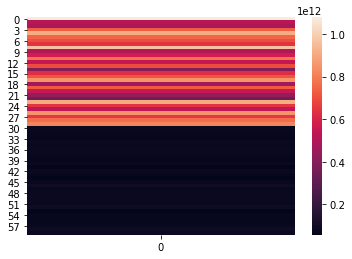

In [14]:
print(gradients_before_burnin[:D].sum())
print(gradients_before_burnin[D:].sum())
sns.heatmap(gradients_before_burnin.clone().detach().cpu().numpy()[:, np.newaxis])


tensor(inf, device='cuda:0')
tensor(2.1358e+20, device='cuda:0')


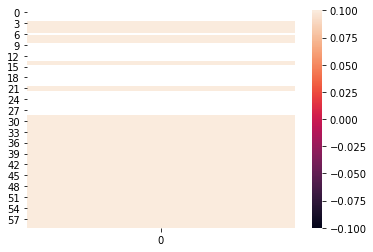

In [15]:
print(gradient_post_burn_in[:D].sum())
print(gradient_post_burn_in[D:].sum())
sns.heatmap(gradient_post_burn_in.clone().detach().cpu().numpy()[:, np.newaxis])

tensor(9959.2969, device='cuda:0')
tensor(1560.7043, device='cuda:0')


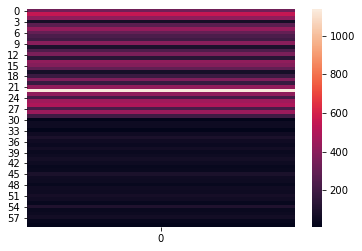

In [16]:
print(subset_indices_before_burnin[:D].sum())
print(subset_indices_before_burnin[D:].sum())
sns.heatmap(subset_indices_before_burnin.clone().detach().cpu().numpy()[:, np.newaxis])

tensor(2127.9458, device='cuda:0')
tensor(752.0540, device='cuda:0')


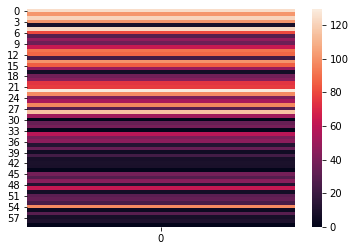

In [17]:
print(subset_indices_post_burnin[:D].sum())
print(subset_indices_post_burnin[(D):].sum())
sns.heatmap(subset_indices_post_burnin.clone().detach().cpu().numpy()[:, np.newaxis])

In [18]:
subset_indices_post_burnin[:(D)].sum() - subset_indices_post_burnin[(D):].sum()

tensor(1375.8918, device='cuda:0')

In [19]:
w = vae_gumbel_truncated.subset_indices.mean(dim = 0)
top_ind = torch.argsort(w, descending = True)[:vae_gumbel_truncated.k]

In [20]:
sum(top_ind < 30)

tensor(19, device='cuda:0')

In [21]:
sum(top_ind >= 30)

tensor(5, device='cuda:0')

In [22]:
sum(w > 0.5)

tensor(21, device='cuda:0')

In [23]:
w

tensor([1.0077, 0.7215, 1.0089, 1.0907, 0.0469, 1.0338, 0.6258, 0.3484, 0.3765,
        0.2010, 0.5842, 0.6481, 0.7750, 0.0542, 0.8612, 0.5028, 0.3997, 0.0312,
        0.2936, 0.5674, 0.5976, 0.8043, 1.0260, 0.7199, 0.3427, 0.4768, 0.7998,
        0.1665, 0.8078, 0.2043, 0.0000, 0.3466, 0.4541, 0.0000, 0.5685, 0.3608,
        0.4796, 0.0847, 0.1513, 0.0975, 0.2853, 0.0156, 0.0470, 0.1602, 0.0157,
        0.2507, 0.4492, 0.3598, 0.0703, 0.5971, 0.0312, 0.1764, 0.2922, 0.1941,
        0.7812, 0.0620, 0.2915, 0.1121, 0.1260, 0.0152], device='cuda:0',
       grad_fn=<MeanBackward1>)

In [24]:
w[w>0.5]

tensor([1.0077, 0.7215, 1.0089, 1.0907, 1.0338, 0.6258, 0.5842, 0.6481, 0.7750,
        0.8612, 0.5028, 0.5674, 0.5976, 0.8043, 1.0260, 0.7199, 0.7998, 0.8078,
        0.5685, 0.5971, 0.7812], device='cuda:0', grad_fn=<IndexBackward>)

**VAE_Gumbel_NInsta test here**

In [25]:
vae_gumbel_truncated = VAE_Gumbel_NInsta(2*D, 100, 20, k = 3*z_size, t = global_t)
vae_gumbel_truncated.to(device)
vae_gumbel_trunc_optimizer = torch.optim.Adam(vae_gumbel_truncated.parameters(), 
                                                lr=lr, 
                                                betas = (b1,b2))



In [26]:
gradients_before_burnin = torch.zeros(train_data.shape[1]).to(device)
gradient_post_burn_in = torch.zeros(train_data.shape[1]).to(device)
subset_indices_before_burnin = torch.zeros(train_data.shape[1]).to(device)
subset_indices_post_burnin = torch.zeros(train_data.shape[1]).to(device)

for epoch in range(1, n_epochs+1):
    grads=train_truncated_with_gradients(train_data, vae_gumbel_truncated, 
                                                      vae_gumbel_trunc_optimizer, 
                                                      epoch, 
                                                      batch_size, 
                                                      Dim = 2*D)
    
    vae_gumbel_truncated.t = max(0.001, vae_gumbel_truncated.t * 0.99)
    if epoch <=(n_epochs//5*4):
        gradients_before_burnin += grads
        with torch.no_grad():
            subset_indices_before_burnin += vae_gumbel_truncated.subset_indices.view(-1)
    if epoch > (n_epochs//5*4):
        gradient_post_burn_in += grads
        with torch.no_grad():
            subset_indices_post_burnin += vae_gumbel_truncated.subset_indices.view(-1)

Train Epoch: 1 [0/8000 (0%)]	Loss: 41.294006
Train Epoch: 1 [1280/8000 (16%)]	Loss: 40.674961
Train Epoch: 1 [2560/8000 (32%)]	Loss: 40.221031
Train Epoch: 1 [3840/8000 (48%)]	Loss: 39.730396
Train Epoch: 1 [5120/8000 (64%)]	Loss: 39.082882
Train Epoch: 1 [6400/8000 (80%)]	Loss: 38.695461
Train Epoch: 1 [7680/8000 (96%)]	Loss: 38.169300
====> Epoch: 1 Average loss: 39.6300
Train Epoch: 2 [0/8000 (0%)]	Loss: 38.003162
Train Epoch: 2 [1280/8000 (16%)]	Loss: 37.516251
Train Epoch: 2 [2560/8000 (32%)]	Loss: 36.777893
Train Epoch: 2 [3840/8000 (48%)]	Loss: 36.157810
Train Epoch: 2 [5120/8000 (64%)]	Loss: 35.287170
Train Epoch: 2 [6400/8000 (80%)]	Loss: 35.275192
Train Epoch: 2 [7680/8000 (96%)]	Loss: 34.297264
====> Epoch: 2 Average loss: 36.0261
Train Epoch: 3 [0/8000 (0%)]	Loss: 34.226944
Train Epoch: 3 [1280/8000 (16%)]	Loss: 34.083256
Train Epoch: 3 [2560/8000 (32%)]	Loss: 34.100769
Train Epoch: 3 [3840/8000 (48%)]	Loss: 33.873367
Train Epoch: 3 [5120/8000 (64%)]	Loss: 33.942493
Train E

Train Epoch: 22 [6400/8000 (80%)]	Loss: 31.282536
Train Epoch: 22 [7680/8000 (96%)]	Loss: 31.381838
====> Epoch: 22 Average loss: 31.2099
Train Epoch: 23 [0/8000 (0%)]	Loss: 31.025547
Train Epoch: 23 [1280/8000 (16%)]	Loss: 31.291489
Train Epoch: 23 [2560/8000 (32%)]	Loss: 31.050579
Train Epoch: 23 [3840/8000 (48%)]	Loss: 30.966213
Train Epoch: 23 [5120/8000 (64%)]	Loss: 30.993820
Train Epoch: 23 [6400/8000 (80%)]	Loss: 31.017805
Train Epoch: 23 [7680/8000 (96%)]	Loss: 31.036785
====> Epoch: 23 Average loss: 31.1402
Train Epoch: 24 [0/8000 (0%)]	Loss: 31.918943
Train Epoch: 24 [1280/8000 (16%)]	Loss: 31.320900
Train Epoch: 24 [2560/8000 (32%)]	Loss: 31.211248
Train Epoch: 24 [3840/8000 (48%)]	Loss: 31.059959
Train Epoch: 24 [5120/8000 (64%)]	Loss: 30.856218
Train Epoch: 24 [6400/8000 (80%)]	Loss: 31.227531
Train Epoch: 24 [7680/8000 (96%)]	Loss: 31.224648
====> Epoch: 24 Average loss: 31.0960
Train Epoch: 25 [0/8000 (0%)]	Loss: 31.112539
Train Epoch: 25 [1280/8000 (16%)]	Loss: 31.36223

Train Epoch: 44 [1280/8000 (16%)]	Loss: 30.391024
Train Epoch: 44 [2560/8000 (32%)]	Loss: 30.638435
Train Epoch: 44 [3840/8000 (48%)]	Loss: 30.346529
Train Epoch: 44 [5120/8000 (64%)]	Loss: 30.761217
Train Epoch: 44 [6400/8000 (80%)]	Loss: 30.469156
Train Epoch: 44 [7680/8000 (96%)]	Loss: 30.778421
====> Epoch: 44 Average loss: 30.5884
Train Epoch: 45 [0/8000 (0%)]	Loss: 30.483011
Train Epoch: 45 [1280/8000 (16%)]	Loss: 30.588219
Train Epoch: 45 [2560/8000 (32%)]	Loss: 30.309889
Train Epoch: 45 [3840/8000 (48%)]	Loss: 30.146250
Train Epoch: 45 [5120/8000 (64%)]	Loss: 30.647715
Train Epoch: 45 [6400/8000 (80%)]	Loss: 30.454983
Train Epoch: 45 [7680/8000 (96%)]	Loss: 30.327620
====> Epoch: 45 Average loss: 30.5869
Train Epoch: 46 [0/8000 (0%)]	Loss: 30.521866
Train Epoch: 46 [1280/8000 (16%)]	Loss: 30.603550
Train Epoch: 46 [2560/8000 (32%)]	Loss: 30.565311
Train Epoch: 46 [3840/8000 (48%)]	Loss: 30.677940
Train Epoch: 46 [5120/8000 (64%)]	Loss: 30.583948
Train Epoch: 46 [6400/8000 (80%)

Train Epoch: 65 [5120/8000 (64%)]	Loss: 30.504795
Train Epoch: 65 [6400/8000 (80%)]	Loss: 30.165766
Train Epoch: 65 [7680/8000 (96%)]	Loss: 30.314869
====> Epoch: 65 Average loss: 30.4092
Train Epoch: 66 [0/8000 (0%)]	Loss: 30.375870
Train Epoch: 66 [1280/8000 (16%)]	Loss: 30.395910
Train Epoch: 66 [2560/8000 (32%)]	Loss: 30.283554
Train Epoch: 66 [3840/8000 (48%)]	Loss: 30.771353
Train Epoch: 66 [5120/8000 (64%)]	Loss: 30.294895
Train Epoch: 66 [6400/8000 (80%)]	Loss: 30.121487
Train Epoch: 66 [7680/8000 (96%)]	Loss: 30.338730
====> Epoch: 66 Average loss: 30.4054
Train Epoch: 67 [0/8000 (0%)]	Loss: 30.416710
Train Epoch: 67 [1280/8000 (16%)]	Loss: 30.591087
Train Epoch: 67 [2560/8000 (32%)]	Loss: 30.293823
Train Epoch: 67 [3840/8000 (48%)]	Loss: 30.406685
Train Epoch: 67 [5120/8000 (64%)]	Loss: 30.527002
Train Epoch: 67 [6400/8000 (80%)]	Loss: 30.261524
Train Epoch: 67 [7680/8000 (96%)]	Loss: 30.396797
====> Epoch: 67 Average loss: 30.3882
Train Epoch: 68 [0/8000 (0%)]	Loss: 30.38037

Train Epoch: 87 [1280/8000 (16%)]	Loss: 30.178507
Train Epoch: 87 [2560/8000 (32%)]	Loss: 30.046175
Train Epoch: 87 [3840/8000 (48%)]	Loss: 30.250492
Train Epoch: 87 [5120/8000 (64%)]	Loss: 30.332193
Train Epoch: 87 [6400/8000 (80%)]	Loss: 30.362762
Train Epoch: 87 [7680/8000 (96%)]	Loss: 29.891991
====> Epoch: 87 Average loss: 30.3031
Train Epoch: 88 [0/8000 (0%)]	Loss: 30.182297
Train Epoch: 88 [1280/8000 (16%)]	Loss: 30.169449
Train Epoch: 88 [2560/8000 (32%)]	Loss: 30.114155
Train Epoch: 88 [3840/8000 (48%)]	Loss: 30.305826
Train Epoch: 88 [5120/8000 (64%)]	Loss: 30.077404
Train Epoch: 88 [6400/8000 (80%)]	Loss: 30.075031
Train Epoch: 88 [7680/8000 (96%)]	Loss: 30.232018
====> Epoch: 88 Average loss: 30.2972
Train Epoch: 89 [0/8000 (0%)]	Loss: 30.257387
Train Epoch: 89 [1280/8000 (16%)]	Loss: 30.601273
Train Epoch: 89 [2560/8000 (32%)]	Loss: 30.366232
Train Epoch: 89 [3840/8000 (48%)]	Loss: 30.206963
Train Epoch: 89 [5120/8000 (64%)]	Loss: 30.453295
Train Epoch: 89 [6400/8000 (80%)

Train Epoch: 108 [3840/8000 (48%)]	Loss: 30.096375
Train Epoch: 108 [5120/8000 (64%)]	Loss: 30.470484
Train Epoch: 108 [6400/8000 (80%)]	Loss: 30.071169
Train Epoch: 108 [7680/8000 (96%)]	Loss: 30.323212
====> Epoch: 108 Average loss: 30.2730
Train Epoch: 109 [0/8000 (0%)]	Loss: 29.916391
Train Epoch: 109 [1280/8000 (16%)]	Loss: 30.356712
Train Epoch: 109 [2560/8000 (32%)]	Loss: 30.188297
Train Epoch: 109 [3840/8000 (48%)]	Loss: 30.205364
Train Epoch: 109 [5120/8000 (64%)]	Loss: 30.135725
Train Epoch: 109 [6400/8000 (80%)]	Loss: 30.342896
Train Epoch: 109 [7680/8000 (96%)]	Loss: 30.006624
====> Epoch: 109 Average loss: 30.2654
Train Epoch: 110 [0/8000 (0%)]	Loss: 30.321934
Train Epoch: 110 [1280/8000 (16%)]	Loss: 30.168152
Train Epoch: 110 [2560/8000 (32%)]	Loss: 30.525772
Train Epoch: 110 [3840/8000 (48%)]	Loss: 30.619318
Train Epoch: 110 [5120/8000 (64%)]	Loss: 30.277552
Train Epoch: 110 [6400/8000 (80%)]	Loss: 30.594578
Train Epoch: 110 [7680/8000 (96%)]	Loss: 30.283054
====> Epoch:

Train Epoch: 129 [3840/8000 (48%)]	Loss: 30.300077
Train Epoch: 129 [5120/8000 (64%)]	Loss: 30.284035
Train Epoch: 129 [6400/8000 (80%)]	Loss: 30.272709
Train Epoch: 129 [7680/8000 (96%)]	Loss: 30.167391
====> Epoch: 129 Average loss: 30.2379
Train Epoch: 130 [0/8000 (0%)]	Loss: 30.419777
Train Epoch: 130 [1280/8000 (16%)]	Loss: 30.234077
Train Epoch: 130 [2560/8000 (32%)]	Loss: 30.203911
Train Epoch: 130 [3840/8000 (48%)]	Loss: 30.392639
Train Epoch: 130 [5120/8000 (64%)]	Loss: 29.997576
Train Epoch: 130 [6400/8000 (80%)]	Loss: 30.049372
Train Epoch: 130 [7680/8000 (96%)]	Loss: 30.099876
====> Epoch: 130 Average loss: 30.2489
Train Epoch: 131 [0/8000 (0%)]	Loss: 30.265560
Train Epoch: 131 [1280/8000 (16%)]	Loss: 30.282536
Train Epoch: 131 [2560/8000 (32%)]	Loss: 30.135750
Train Epoch: 131 [3840/8000 (48%)]	Loss: 30.171234
Train Epoch: 131 [5120/8000 (64%)]	Loss: 29.803310
Train Epoch: 131 [6400/8000 (80%)]	Loss: 30.277721
Train Epoch: 131 [7680/8000 (96%)]	Loss: 30.091141
====> Epoch:

Train Epoch: 150 [3840/8000 (48%)]	Loss: 29.884279
Train Epoch: 150 [5120/8000 (64%)]	Loss: 29.851887
Train Epoch: 150 [6400/8000 (80%)]	Loss: 30.449347
Train Epoch: 150 [7680/8000 (96%)]	Loss: 30.058388
====> Epoch: 150 Average loss: 30.2107
Train Epoch: 151 [0/8000 (0%)]	Loss: 30.360134
Train Epoch: 151 [1280/8000 (16%)]	Loss: 30.410763
Train Epoch: 151 [2560/8000 (32%)]	Loss: 30.515905
Train Epoch: 151 [3840/8000 (48%)]	Loss: 30.636078
Train Epoch: 151 [5120/8000 (64%)]	Loss: 30.428680
Train Epoch: 151 [6400/8000 (80%)]	Loss: 30.070696
Train Epoch: 151 [7680/8000 (96%)]	Loss: 30.312197
====> Epoch: 151 Average loss: 30.2140
Train Epoch: 152 [0/8000 (0%)]	Loss: 30.043888
Train Epoch: 152 [1280/8000 (16%)]	Loss: 30.260092
Train Epoch: 152 [2560/8000 (32%)]	Loss: 30.433641
Train Epoch: 152 [3840/8000 (48%)]	Loss: 30.696085
Train Epoch: 152 [5120/8000 (64%)]	Loss: 30.505888
Train Epoch: 152 [6400/8000 (80%)]	Loss: 30.654621
Train Epoch: 152 [7680/8000 (96%)]	Loss: 30.448204
====> Epoch:

Train Epoch: 171 [3840/8000 (48%)]	Loss: 30.382788
Train Epoch: 171 [5120/8000 (64%)]	Loss: 30.348322
Train Epoch: 171 [6400/8000 (80%)]	Loss: 30.213768
Train Epoch: 171 [7680/8000 (96%)]	Loss: 30.093328
====> Epoch: 171 Average loss: 30.2098
Train Epoch: 172 [0/8000 (0%)]	Loss: 30.419416
Train Epoch: 172 [1280/8000 (16%)]	Loss: 30.374466
Train Epoch: 172 [2560/8000 (32%)]	Loss: 30.560352
Train Epoch: 172 [3840/8000 (48%)]	Loss: 30.192398
Train Epoch: 172 [5120/8000 (64%)]	Loss: 30.718836
Train Epoch: 172 [6400/8000 (80%)]	Loss: 30.384720
Train Epoch: 172 [7680/8000 (96%)]	Loss: 30.365643
====> Epoch: 172 Average loss: 30.1942
Train Epoch: 173 [0/8000 (0%)]	Loss: 30.342354
Train Epoch: 173 [1280/8000 (16%)]	Loss: 30.363396
Train Epoch: 173 [2560/8000 (32%)]	Loss: 29.923859
Train Epoch: 173 [3840/8000 (48%)]	Loss: 30.206079
Train Epoch: 173 [5120/8000 (64%)]	Loss: 30.238119
Train Epoch: 173 [6400/8000 (80%)]	Loss: 30.006392
Train Epoch: 173 [7680/8000 (96%)]	Loss: 30.031677
====> Epoch:

Train Epoch: 192 [3840/8000 (48%)]	Loss: 30.131165
Train Epoch: 192 [5120/8000 (64%)]	Loss: 30.166727
Train Epoch: 192 [6400/8000 (80%)]	Loss: 30.362795
Train Epoch: 192 [7680/8000 (96%)]	Loss: 30.088804
====> Epoch: 192 Average loss: 30.2174
Train Epoch: 193 [0/8000 (0%)]	Loss: 30.000193
Train Epoch: 193 [1280/8000 (16%)]	Loss: 30.587288
Train Epoch: 193 [2560/8000 (32%)]	Loss: 30.289850
Train Epoch: 193 [3840/8000 (48%)]	Loss: 30.163725
Train Epoch: 193 [5120/8000 (64%)]	Loss: 30.369944
Train Epoch: 193 [6400/8000 (80%)]	Loss: 29.901571
Train Epoch: 193 [7680/8000 (96%)]	Loss: 30.363712
====> Epoch: 193 Average loss: 30.1870
Train Epoch: 194 [0/8000 (0%)]	Loss: 30.007215
Train Epoch: 194 [1280/8000 (16%)]	Loss: 30.274511
Train Epoch: 194 [2560/8000 (32%)]	Loss: 30.058710
Train Epoch: 194 [3840/8000 (48%)]	Loss: 29.954018
Train Epoch: 194 [5120/8000 (64%)]	Loss: 30.089106
Train Epoch: 194 [6400/8000 (80%)]	Loss: 30.106995
Train Epoch: 194 [7680/8000 (96%)]	Loss: 30.161095
====> Epoch:

Train Epoch: 213 [3840/8000 (48%)]	Loss: 30.151472
Train Epoch: 213 [5120/8000 (64%)]	Loss: 30.430012
Train Epoch: 213 [6400/8000 (80%)]	Loss: 30.438835
Train Epoch: 213 [7680/8000 (96%)]	Loss: 30.664669
====> Epoch: 213 Average loss: 30.2313
Train Epoch: 214 [0/8000 (0%)]	Loss: 30.115610
Train Epoch: 214 [1280/8000 (16%)]	Loss: 30.152273
Train Epoch: 214 [2560/8000 (32%)]	Loss: 30.545355
Train Epoch: 214 [3840/8000 (48%)]	Loss: 30.214430
Train Epoch: 214 [5120/8000 (64%)]	Loss: 30.416765
Train Epoch: 214 [6400/8000 (80%)]	Loss: 30.481083
Train Epoch: 214 [7680/8000 (96%)]	Loss: 30.650183
====> Epoch: 214 Average loss: 30.2039
Train Epoch: 215 [0/8000 (0%)]	Loss: 30.464237
Train Epoch: 215 [1280/8000 (16%)]	Loss: 30.322521
Train Epoch: 215 [2560/8000 (32%)]	Loss: 29.698299
Train Epoch: 215 [3840/8000 (48%)]	Loss: 30.096378
Train Epoch: 215 [5120/8000 (64%)]	Loss: 30.242702
Train Epoch: 215 [6400/8000 (80%)]	Loss: 29.914900
Train Epoch: 215 [7680/8000 (96%)]	Loss: 30.248981
====> Epoch:

Train Epoch: 234 [3840/8000 (48%)]	Loss: 30.089245
Train Epoch: 234 [5120/8000 (64%)]	Loss: 30.026051
Train Epoch: 234 [6400/8000 (80%)]	Loss: 30.198946
Train Epoch: 234 [7680/8000 (96%)]	Loss: 30.062700
====> Epoch: 234 Average loss: 30.1913
Train Epoch: 235 [0/8000 (0%)]	Loss: 30.408146
Train Epoch: 235 [1280/8000 (16%)]	Loss: 30.216909
Train Epoch: 235 [2560/8000 (32%)]	Loss: 29.922234
Train Epoch: 235 [3840/8000 (48%)]	Loss: 30.513023
Train Epoch: 235 [5120/8000 (64%)]	Loss: 30.387337
Train Epoch: 235 [6400/8000 (80%)]	Loss: 30.375715
Train Epoch: 235 [7680/8000 (96%)]	Loss: 30.271023
====> Epoch: 235 Average loss: 30.2091
Train Epoch: 236 [0/8000 (0%)]	Loss: 30.152571
Train Epoch: 236 [1280/8000 (16%)]	Loss: 30.185419
Train Epoch: 236 [2560/8000 (32%)]	Loss: 30.069292
Train Epoch: 236 [3840/8000 (48%)]	Loss: 30.268948
Train Epoch: 236 [5120/8000 (64%)]	Loss: 29.933870
Train Epoch: 236 [6400/8000 (80%)]	Loss: 30.068043
Train Epoch: 236 [7680/8000 (96%)]	Loss: 30.040859
====> Epoch:

Train Epoch: 255 [3840/8000 (48%)]	Loss: 30.380520
Train Epoch: 255 [5120/8000 (64%)]	Loss: 30.070347
Train Epoch: 255 [6400/8000 (80%)]	Loss: 30.090445
Train Epoch: 255 [7680/8000 (96%)]	Loss: 30.184181
====> Epoch: 255 Average loss: 30.1943
Train Epoch: 256 [0/8000 (0%)]	Loss: 30.159887
Train Epoch: 256 [1280/8000 (16%)]	Loss: 30.230589
Train Epoch: 256 [2560/8000 (32%)]	Loss: 29.920778
Train Epoch: 256 [3840/8000 (48%)]	Loss: 30.245010
Train Epoch: 256 [5120/8000 (64%)]	Loss: 29.940693
Train Epoch: 256 [6400/8000 (80%)]	Loss: 30.086391
Train Epoch: 256 [7680/8000 (96%)]	Loss: 30.161634
====> Epoch: 256 Average loss: 30.2055
Train Epoch: 257 [0/8000 (0%)]	Loss: 30.491133
Train Epoch: 257 [1280/8000 (16%)]	Loss: 30.469748
Train Epoch: 257 [2560/8000 (32%)]	Loss: 30.407446
Train Epoch: 257 [3840/8000 (48%)]	Loss: 30.079481
Train Epoch: 257 [5120/8000 (64%)]	Loss: 29.994938
Train Epoch: 257 [6400/8000 (80%)]	Loss: 30.361095
Train Epoch: 257 [7680/8000 (96%)]	Loss: 29.972916
====> Epoch:

Train Epoch: 276 [3840/8000 (48%)]	Loss: 30.475616
Train Epoch: 276 [5120/8000 (64%)]	Loss: 29.919579
Train Epoch: 276 [6400/8000 (80%)]	Loss: 30.803923
Train Epoch: 276 [7680/8000 (96%)]	Loss: 30.224617
====> Epoch: 276 Average loss: 30.1819
Train Epoch: 277 [0/8000 (0%)]	Loss: 30.076050
Train Epoch: 277 [1280/8000 (16%)]	Loss: 29.776440
Train Epoch: 277 [2560/8000 (32%)]	Loss: 30.430311
Train Epoch: 277 [3840/8000 (48%)]	Loss: 30.116207
Train Epoch: 277 [5120/8000 (64%)]	Loss: 29.936178
Train Epoch: 277 [6400/8000 (80%)]	Loss: 29.872826
Train Epoch: 277 [7680/8000 (96%)]	Loss: 30.453358
====> Epoch: 277 Average loss: 30.1931
Train Epoch: 278 [0/8000 (0%)]	Loss: 30.105238
Train Epoch: 278 [1280/8000 (16%)]	Loss: 29.989845
Train Epoch: 278 [2560/8000 (32%)]	Loss: 30.199198
Train Epoch: 278 [3840/8000 (48%)]	Loss: 29.922333
Train Epoch: 278 [5120/8000 (64%)]	Loss: 30.197952
Train Epoch: 278 [6400/8000 (80%)]	Loss: 30.565453
Train Epoch: 278 [7680/8000 (96%)]	Loss: 29.864925
====> Epoch:

Train Epoch: 297 [3840/8000 (48%)]	Loss: 30.179266
Train Epoch: 297 [5120/8000 (64%)]	Loss: 30.111853
Train Epoch: 297 [6400/8000 (80%)]	Loss: 30.151140
Train Epoch: 297 [7680/8000 (96%)]	Loss: 30.060818
====> Epoch: 297 Average loss: 30.1663
Train Epoch: 298 [0/8000 (0%)]	Loss: 30.275993
Train Epoch: 298 [1280/8000 (16%)]	Loss: 30.268492
Train Epoch: 298 [2560/8000 (32%)]	Loss: 29.984135
Train Epoch: 298 [3840/8000 (48%)]	Loss: 30.172707
Train Epoch: 298 [5120/8000 (64%)]	Loss: 30.364231
Train Epoch: 298 [6400/8000 (80%)]	Loss: 30.218153
Train Epoch: 298 [7680/8000 (96%)]	Loss: 30.609564
====> Epoch: 298 Average loss: 30.1779
Train Epoch: 299 [0/8000 (0%)]	Loss: 30.041473
Train Epoch: 299 [1280/8000 (16%)]	Loss: 30.299482
Train Epoch: 299 [2560/8000 (32%)]	Loss: 30.195595
Train Epoch: 299 [3840/8000 (48%)]	Loss: 30.448664
Train Epoch: 299 [5120/8000 (64%)]	Loss: 30.196526
Train Epoch: 299 [6400/8000 (80%)]	Loss: 30.198639
Train Epoch: 299 [7680/8000 (96%)]	Loss: 30.287682
====> Epoch:

Train Epoch: 318 [3840/8000 (48%)]	Loss: 30.003923
Train Epoch: 318 [5120/8000 (64%)]	Loss: 30.297226
Train Epoch: 318 [6400/8000 (80%)]	Loss: 30.289658
Train Epoch: 318 [7680/8000 (96%)]	Loss: 30.121279
====> Epoch: 318 Average loss: 30.1396
Train Epoch: 319 [0/8000 (0%)]	Loss: 30.362047
Train Epoch: 319 [1280/8000 (16%)]	Loss: 30.360249
Train Epoch: 319 [2560/8000 (32%)]	Loss: 30.392157
Train Epoch: 319 [3840/8000 (48%)]	Loss: 30.043024
Train Epoch: 319 [5120/8000 (64%)]	Loss: 30.017567
Train Epoch: 319 [6400/8000 (80%)]	Loss: 29.989334
Train Epoch: 319 [7680/8000 (96%)]	Loss: 30.157738
====> Epoch: 319 Average loss: 30.1492
Train Epoch: 320 [0/8000 (0%)]	Loss: 29.938625
Train Epoch: 320 [1280/8000 (16%)]	Loss: 30.286215
Train Epoch: 320 [2560/8000 (32%)]	Loss: 30.080505
Train Epoch: 320 [3840/8000 (48%)]	Loss: 30.348793
Train Epoch: 320 [5120/8000 (64%)]	Loss: 30.059395
Train Epoch: 320 [6400/8000 (80%)]	Loss: 30.182913
Train Epoch: 320 [7680/8000 (96%)]	Loss: 30.301086
====> Epoch:

Train Epoch: 339 [3840/8000 (48%)]	Loss: 30.182997
Train Epoch: 339 [5120/8000 (64%)]	Loss: 30.089581
Train Epoch: 339 [6400/8000 (80%)]	Loss: 30.101091
Train Epoch: 339 [7680/8000 (96%)]	Loss: 30.220768
====> Epoch: 339 Average loss: 30.1223
Train Epoch: 340 [0/8000 (0%)]	Loss: 30.139288
Train Epoch: 340 [1280/8000 (16%)]	Loss: 29.927477
Train Epoch: 340 [2560/8000 (32%)]	Loss: 29.779747
Train Epoch: 340 [3840/8000 (48%)]	Loss: 30.159437
Train Epoch: 340 [5120/8000 (64%)]	Loss: 29.806047
Train Epoch: 340 [6400/8000 (80%)]	Loss: 30.133924
Train Epoch: 340 [7680/8000 (96%)]	Loss: 30.092829
====> Epoch: 340 Average loss: 30.1070
Train Epoch: 341 [0/8000 (0%)]	Loss: 30.256426
Train Epoch: 341 [1280/8000 (16%)]	Loss: 30.089981
Train Epoch: 341 [2560/8000 (32%)]	Loss: 30.358246
Train Epoch: 341 [3840/8000 (48%)]	Loss: 30.125885
Train Epoch: 341 [5120/8000 (64%)]	Loss: 30.268991
Train Epoch: 341 [6400/8000 (80%)]	Loss: 30.330952
Train Epoch: 341 [7680/8000 (96%)]	Loss: 30.017445
====> Epoch:

Train Epoch: 360 [3840/8000 (48%)]	Loss: 30.420675
Train Epoch: 360 [5120/8000 (64%)]	Loss: 29.766033
Train Epoch: 360 [6400/8000 (80%)]	Loss: 30.296032
Train Epoch: 360 [7680/8000 (96%)]	Loss: 30.230341
====> Epoch: 360 Average loss: 30.0845
Train Epoch: 361 [0/8000 (0%)]	Loss: 30.345486
Train Epoch: 361 [1280/8000 (16%)]	Loss: 30.273596
Train Epoch: 361 [2560/8000 (32%)]	Loss: 29.993427
Train Epoch: 361 [3840/8000 (48%)]	Loss: 30.061996
Train Epoch: 361 [5120/8000 (64%)]	Loss: 30.131536
Train Epoch: 361 [6400/8000 (80%)]	Loss: 30.421658
Train Epoch: 361 [7680/8000 (96%)]	Loss: 30.105413
====> Epoch: 361 Average loss: 30.1014
Train Epoch: 362 [0/8000 (0%)]	Loss: 30.072397
Train Epoch: 362 [1280/8000 (16%)]	Loss: 29.922609
Train Epoch: 362 [2560/8000 (32%)]	Loss: 30.309811
Train Epoch: 362 [3840/8000 (48%)]	Loss: 30.046808
Train Epoch: 362 [5120/8000 (64%)]	Loss: 30.126682
Train Epoch: 362 [6400/8000 (80%)]	Loss: 29.918795
Train Epoch: 362 [7680/8000 (96%)]	Loss: 30.074749
====> Epoch:

Train Epoch: 381 [3840/8000 (48%)]	Loss: 29.613770
Train Epoch: 381 [5120/8000 (64%)]	Loss: 29.724655
Train Epoch: 381 [6400/8000 (80%)]	Loss: 29.804926
Train Epoch: 381 [7680/8000 (96%)]	Loss: 29.961620
====> Epoch: 381 Average loss: 30.0623
Train Epoch: 382 [0/8000 (0%)]	Loss: 30.183109
Train Epoch: 382 [1280/8000 (16%)]	Loss: 29.997011
Train Epoch: 382 [2560/8000 (32%)]	Loss: 29.902405
Train Epoch: 382 [3840/8000 (48%)]	Loss: 29.969408
Train Epoch: 382 [5120/8000 (64%)]	Loss: 30.207787
Train Epoch: 382 [6400/8000 (80%)]	Loss: 30.282871
Train Epoch: 382 [7680/8000 (96%)]	Loss: 29.998310
====> Epoch: 382 Average loss: 30.0512
Train Epoch: 383 [0/8000 (0%)]	Loss: 30.269903
Train Epoch: 383 [1280/8000 (16%)]	Loss: 30.299252
Train Epoch: 383 [2560/8000 (32%)]	Loss: 30.171640
Train Epoch: 383 [3840/8000 (48%)]	Loss: 29.931541
Train Epoch: 383 [5120/8000 (64%)]	Loss: 29.629395
Train Epoch: 383 [6400/8000 (80%)]	Loss: 29.757893
Train Epoch: 383 [7680/8000 (96%)]	Loss: 29.963238
====> Epoch:

Train Epoch: 402 [3840/8000 (48%)]	Loss: 30.175789
Train Epoch: 402 [5120/8000 (64%)]	Loss: 29.887989
Train Epoch: 402 [6400/8000 (80%)]	Loss: 29.995186
Train Epoch: 402 [7680/8000 (96%)]	Loss: 29.969345
====> Epoch: 402 Average loss: 30.0551
Train Epoch: 403 [0/8000 (0%)]	Loss: 30.010254
Train Epoch: 403 [1280/8000 (16%)]	Loss: 29.954784
Train Epoch: 403 [2560/8000 (32%)]	Loss: 30.040890
Train Epoch: 403 [3840/8000 (48%)]	Loss: 30.265469
Train Epoch: 403 [5120/8000 (64%)]	Loss: 30.322939
Train Epoch: 403 [6400/8000 (80%)]	Loss: 30.151382
Train Epoch: 403 [7680/8000 (96%)]	Loss: 30.137228
====> Epoch: 403 Average loss: 30.0447
Train Epoch: 404 [0/8000 (0%)]	Loss: 29.941679
Train Epoch: 404 [1280/8000 (16%)]	Loss: 30.045923
Train Epoch: 404 [2560/8000 (32%)]	Loss: 30.126509
Train Epoch: 404 [3840/8000 (48%)]	Loss: 30.178600
Train Epoch: 404 [5120/8000 (64%)]	Loss: 30.092436
Train Epoch: 404 [6400/8000 (80%)]	Loss: 30.893074
Train Epoch: 404 [7680/8000 (96%)]	Loss: 29.921640
====> Epoch:

Train Epoch: 423 [3840/8000 (48%)]	Loss: 29.934706
Train Epoch: 423 [5120/8000 (64%)]	Loss: 30.004772
Train Epoch: 423 [6400/8000 (80%)]	Loss: 30.037987
Train Epoch: 423 [7680/8000 (96%)]	Loss: 30.034168
====> Epoch: 423 Average loss: 29.9948
Train Epoch: 424 [0/8000 (0%)]	Loss: 30.033138
Train Epoch: 424 [1280/8000 (16%)]	Loss: 29.767550
Train Epoch: 424 [2560/8000 (32%)]	Loss: 29.940527
Train Epoch: 424 [3840/8000 (48%)]	Loss: 30.218781
Train Epoch: 424 [5120/8000 (64%)]	Loss: 29.631599
Train Epoch: 424 [6400/8000 (80%)]	Loss: 30.001150
Train Epoch: 424 [7680/8000 (96%)]	Loss: 29.915234
====> Epoch: 424 Average loss: 30.0139
Train Epoch: 425 [0/8000 (0%)]	Loss: 30.286678
Train Epoch: 425 [1280/8000 (16%)]	Loss: 30.213602
Train Epoch: 425 [2560/8000 (32%)]	Loss: 29.711617
Train Epoch: 425 [3840/8000 (48%)]	Loss: 29.979036
Train Epoch: 425 [5120/8000 (64%)]	Loss: 30.019054
Train Epoch: 425 [6400/8000 (80%)]	Loss: 29.868860
Train Epoch: 425 [7680/8000 (96%)]	Loss: 30.085268
====> Epoch:

Train Epoch: 444 [3840/8000 (48%)]	Loss: 29.783510
Train Epoch: 444 [5120/8000 (64%)]	Loss: 29.813013
Train Epoch: 444 [6400/8000 (80%)]	Loss: 29.951902
Train Epoch: 444 [7680/8000 (96%)]	Loss: 29.865713
====> Epoch: 444 Average loss: 29.9914
Train Epoch: 445 [0/8000 (0%)]	Loss: 29.677734
Train Epoch: 445 [1280/8000 (16%)]	Loss: 30.274433
Train Epoch: 445 [2560/8000 (32%)]	Loss: 30.326160
Train Epoch: 445 [3840/8000 (48%)]	Loss: 30.068733
Train Epoch: 445 [5120/8000 (64%)]	Loss: 29.643242
Train Epoch: 445 [6400/8000 (80%)]	Loss: 29.815924
Train Epoch: 445 [7680/8000 (96%)]	Loss: 30.231411
====> Epoch: 445 Average loss: 29.9869
Train Epoch: 446 [0/8000 (0%)]	Loss: 30.131243
Train Epoch: 446 [1280/8000 (16%)]	Loss: 29.837784
Train Epoch: 446 [2560/8000 (32%)]	Loss: 30.374887
Train Epoch: 446 [3840/8000 (48%)]	Loss: 29.875032
Train Epoch: 446 [5120/8000 (64%)]	Loss: 29.824734
Train Epoch: 446 [6400/8000 (80%)]	Loss: 30.213346
Train Epoch: 446 [7680/8000 (96%)]	Loss: 30.115992
====> Epoch:

Train Epoch: 465 [3840/8000 (48%)]	Loss: 30.051725
Train Epoch: 465 [5120/8000 (64%)]	Loss: 30.155891
Train Epoch: 465 [6400/8000 (80%)]	Loss: 30.266390
Train Epoch: 465 [7680/8000 (96%)]	Loss: 30.112345
====> Epoch: 465 Average loss: 29.9813
Train Epoch: 466 [0/8000 (0%)]	Loss: 30.215967
Train Epoch: 466 [1280/8000 (16%)]	Loss: 29.864027
Train Epoch: 466 [2560/8000 (32%)]	Loss: 29.917206
Train Epoch: 466 [3840/8000 (48%)]	Loss: 30.123886
Train Epoch: 466 [5120/8000 (64%)]	Loss: 29.753468
Train Epoch: 466 [6400/8000 (80%)]	Loss: 29.767427
Train Epoch: 466 [7680/8000 (96%)]	Loss: 29.833212
====> Epoch: 466 Average loss: 29.9587
Train Epoch: 467 [0/8000 (0%)]	Loss: 29.881592
Train Epoch: 467 [1280/8000 (16%)]	Loss: 29.924387
Train Epoch: 467 [2560/8000 (32%)]	Loss: 30.012972
Train Epoch: 467 [3840/8000 (48%)]	Loss: 30.130840
Train Epoch: 467 [5120/8000 (64%)]	Loss: 30.124468
Train Epoch: 467 [6400/8000 (80%)]	Loss: 29.906775
Train Epoch: 467 [7680/8000 (96%)]	Loss: 29.990211
====> Epoch:

Train Epoch: 486 [3840/8000 (48%)]	Loss: 29.915602
Train Epoch: 486 [5120/8000 (64%)]	Loss: 29.973923
Train Epoch: 486 [6400/8000 (80%)]	Loss: 30.091537
Train Epoch: 486 [7680/8000 (96%)]	Loss: 29.607044
====> Epoch: 486 Average loss: 29.9353
Train Epoch: 487 [0/8000 (0%)]	Loss: 30.092516
Train Epoch: 487 [1280/8000 (16%)]	Loss: 30.088530
Train Epoch: 487 [2560/8000 (32%)]	Loss: 29.622282
Train Epoch: 487 [3840/8000 (48%)]	Loss: 30.337719
Train Epoch: 487 [5120/8000 (64%)]	Loss: 29.794832
Train Epoch: 487 [6400/8000 (80%)]	Loss: 29.543119
Train Epoch: 487 [7680/8000 (96%)]	Loss: 30.029179
====> Epoch: 487 Average loss: 29.9400
Train Epoch: 488 [0/8000 (0%)]	Loss: 29.849018
Train Epoch: 488 [1280/8000 (16%)]	Loss: 30.028162
Train Epoch: 488 [2560/8000 (32%)]	Loss: 30.017376
Train Epoch: 488 [3840/8000 (48%)]	Loss: 30.102016
Train Epoch: 488 [5120/8000 (64%)]	Loss: 29.970299
Train Epoch: 488 [6400/8000 (80%)]	Loss: 29.745474
Train Epoch: 488 [7680/8000 (96%)]	Loss: 30.116478
====> Epoch:

Train Epoch: 507 [3840/8000 (48%)]	Loss: 29.571465
Train Epoch: 507 [5120/8000 (64%)]	Loss: 29.912592
Train Epoch: 507 [6400/8000 (80%)]	Loss: 29.438740
Train Epoch: 507 [7680/8000 (96%)]	Loss: 30.135162
====> Epoch: 507 Average loss: 29.9051
Train Epoch: 508 [0/8000 (0%)]	Loss: 29.743870
Train Epoch: 508 [1280/8000 (16%)]	Loss: 29.831871
Train Epoch: 508 [2560/8000 (32%)]	Loss: 29.950203
Train Epoch: 508 [3840/8000 (48%)]	Loss: 29.760891
Train Epoch: 508 [5120/8000 (64%)]	Loss: 29.563946
Train Epoch: 508 [6400/8000 (80%)]	Loss: 29.741148
Train Epoch: 508 [7680/8000 (96%)]	Loss: 30.269218
====> Epoch: 508 Average loss: 29.9106
Train Epoch: 509 [0/8000 (0%)]	Loss: 29.979746
Train Epoch: 509 [1280/8000 (16%)]	Loss: 29.707491
Train Epoch: 509 [2560/8000 (32%)]	Loss: 29.581871
Train Epoch: 509 [3840/8000 (48%)]	Loss: 30.130003
Train Epoch: 509 [5120/8000 (64%)]	Loss: 30.097424
Train Epoch: 509 [6400/8000 (80%)]	Loss: 29.559305
Train Epoch: 509 [7680/8000 (96%)]	Loss: 29.971350
====> Epoch:

Train Epoch: 528 [3840/8000 (48%)]	Loss: 29.987007
Train Epoch: 528 [5120/8000 (64%)]	Loss: 30.021584
Train Epoch: 528 [6400/8000 (80%)]	Loss: 29.919127
Train Epoch: 528 [7680/8000 (96%)]	Loss: 29.870325
====> Epoch: 528 Average loss: 29.8762
Train Epoch: 529 [0/8000 (0%)]	Loss: 29.683046
Train Epoch: 529 [1280/8000 (16%)]	Loss: 29.778101
Train Epoch: 529 [2560/8000 (32%)]	Loss: 29.956152
Train Epoch: 529 [3840/8000 (48%)]	Loss: 29.714649
Train Epoch: 529 [5120/8000 (64%)]	Loss: 30.005371
Train Epoch: 529 [6400/8000 (80%)]	Loss: 29.844437
Train Epoch: 529 [7680/8000 (96%)]	Loss: 30.134241
====> Epoch: 529 Average loss: 29.8866
Train Epoch: 530 [0/8000 (0%)]	Loss: 29.812834
Train Epoch: 530 [1280/8000 (16%)]	Loss: 30.274837
Train Epoch: 530 [2560/8000 (32%)]	Loss: 29.892214
Train Epoch: 530 [3840/8000 (48%)]	Loss: 29.981167
Train Epoch: 530 [5120/8000 (64%)]	Loss: 29.995932
Train Epoch: 530 [6400/8000 (80%)]	Loss: 29.917274
Train Epoch: 530 [7680/8000 (96%)]	Loss: 29.535563
====> Epoch:

Train Epoch: 549 [3840/8000 (48%)]	Loss: 30.085917
Train Epoch: 549 [5120/8000 (64%)]	Loss: 29.628534
Train Epoch: 549 [6400/8000 (80%)]	Loss: 30.060772
Train Epoch: 549 [7680/8000 (96%)]	Loss: 29.579880
====> Epoch: 549 Average loss: 29.8640
Train Epoch: 550 [0/8000 (0%)]	Loss: 30.037004
Train Epoch: 550 [1280/8000 (16%)]	Loss: 29.857126
Train Epoch: 550 [2560/8000 (32%)]	Loss: 29.966520
Train Epoch: 550 [3840/8000 (48%)]	Loss: 29.920950
Train Epoch: 550 [5120/8000 (64%)]	Loss: 30.084209
Train Epoch: 550 [6400/8000 (80%)]	Loss: 29.467911
Train Epoch: 550 [7680/8000 (96%)]	Loss: 30.004768
====> Epoch: 550 Average loss: 29.8568
Train Epoch: 551 [0/8000 (0%)]	Loss: 29.799965
Train Epoch: 551 [1280/8000 (16%)]	Loss: 30.171125
Train Epoch: 551 [2560/8000 (32%)]	Loss: 29.803900
Train Epoch: 551 [3840/8000 (48%)]	Loss: 29.744596
Train Epoch: 551 [5120/8000 (64%)]	Loss: 29.762976
Train Epoch: 551 [6400/8000 (80%)]	Loss: 30.187262
Train Epoch: 551 [7680/8000 (96%)]	Loss: 29.735924
====> Epoch:

Train Epoch: 570 [3840/8000 (48%)]	Loss: 29.927780
Train Epoch: 570 [5120/8000 (64%)]	Loss: 29.638351
Train Epoch: 570 [6400/8000 (80%)]	Loss: 29.814199
Train Epoch: 570 [7680/8000 (96%)]	Loss: 29.670891
====> Epoch: 570 Average loss: 29.8376
Train Epoch: 571 [0/8000 (0%)]	Loss: 30.067915
Train Epoch: 571 [1280/8000 (16%)]	Loss: 30.012600
Train Epoch: 571 [2560/8000 (32%)]	Loss: 29.759165
Train Epoch: 571 [3840/8000 (48%)]	Loss: 29.905148
Train Epoch: 571 [5120/8000 (64%)]	Loss: 29.786507
Train Epoch: 571 [6400/8000 (80%)]	Loss: 30.082392
Train Epoch: 571 [7680/8000 (96%)]	Loss: 29.704580
====> Epoch: 571 Average loss: 29.8408
Train Epoch: 572 [0/8000 (0%)]	Loss: 29.691250
Train Epoch: 572 [1280/8000 (16%)]	Loss: 29.544600
Train Epoch: 572 [2560/8000 (32%)]	Loss: 29.541388
Train Epoch: 572 [3840/8000 (48%)]	Loss: 29.849571
Train Epoch: 572 [5120/8000 (64%)]	Loss: 29.960392
Train Epoch: 572 [6400/8000 (80%)]	Loss: 29.471373
Train Epoch: 572 [7680/8000 (96%)]	Loss: 29.613537
====> Epoch:

Train Epoch: 591 [3840/8000 (48%)]	Loss: 29.750723
Train Epoch: 591 [5120/8000 (64%)]	Loss: 29.859995
Train Epoch: 591 [6400/8000 (80%)]	Loss: 29.822374
Train Epoch: 591 [7680/8000 (96%)]	Loss: 29.618015
====> Epoch: 591 Average loss: 29.8195
Train Epoch: 592 [0/8000 (0%)]	Loss: 29.671484
Train Epoch: 592 [1280/8000 (16%)]	Loss: 29.769634
Train Epoch: 592 [2560/8000 (32%)]	Loss: 29.661835
Train Epoch: 592 [3840/8000 (48%)]	Loss: 29.839632
Train Epoch: 592 [5120/8000 (64%)]	Loss: 30.055424
Train Epoch: 592 [6400/8000 (80%)]	Loss: 29.674551
Train Epoch: 592 [7680/8000 (96%)]	Loss: 29.917309
====> Epoch: 592 Average loss: 29.8169
Train Epoch: 593 [0/8000 (0%)]	Loss: 29.840458
Train Epoch: 593 [1280/8000 (16%)]	Loss: 29.667416
Train Epoch: 593 [2560/8000 (32%)]	Loss: 29.698488
Train Epoch: 593 [3840/8000 (48%)]	Loss: 29.796671
Train Epoch: 593 [5120/8000 (64%)]	Loss: 29.942127
Train Epoch: 593 [6400/8000 (80%)]	Loss: 29.985533
Train Epoch: 593 [7680/8000 (96%)]	Loss: 29.975321
====> Epoch:

tensor(1.4086e+11, device='cuda:0')
tensor(1.5905e+11, device='cuda:0')


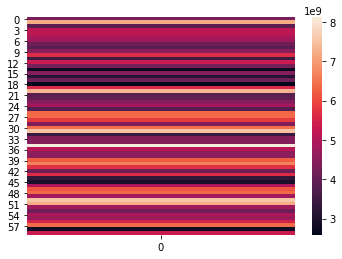

In [27]:
print(gradients_before_burnin[:D].sum())
print(gradients_before_burnin[D:].sum())
sns.heatmap(gradients_before_burnin.clone().detach().cpu().numpy()[:, np.newaxis])


tensor(1.8779e+13, device='cuda:0')
tensor(2.2891e+13, device='cuda:0')


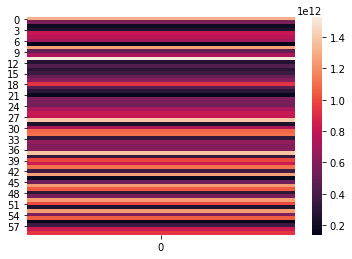

In [28]:
print(gradient_post_burn_in[:D].sum())
print(gradient_post_burn_in[D:].sum())
sns.heatmap(gradient_post_burn_in.clone().detach().cpu().numpy()[:, np.newaxis])

tensor(11040.6406, device='cuda:0')
tensor(479.3577, device='cuda:0')


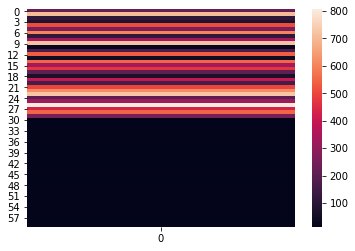

In [29]:
print(subset_indices_before_burnin[:D].sum())
print(subset_indices_before_burnin[D:].sum())
sns.heatmap(subset_indices_before_burnin.clone().detach().cpu().numpy()[:, np.newaxis])

tensor(2878.9263, device='cuda:0')
tensor(1.0740, device='cuda:0')


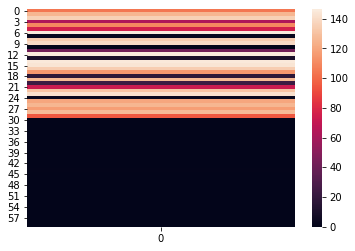

In [30]:
print(subset_indices_post_burnin[:D].sum())
print(subset_indices_post_burnin[(D):].sum())
sns.heatmap(subset_indices_post_burnin.clone().detach().cpu().numpy()[:, np.newaxis])

In [31]:
subset_indices_post_burnin[:(D)].sum() - subset_indices_post_burnin[(D):].sum()

tensor(2877.8523, device='cuda:0')

In [32]:
w = vae_gumbel_truncated.subset_indices.mean(dim = 0)
top_ind = torch.argsort(w, descending = True)[:vae_gumbel_truncated.k]

In [33]:
sum(top_ind < 30)

tensor(24, device='cuda:0')

In [34]:
sum(top_ind >= 30)

tensor(0, device='cuda:0')

In [35]:
sum(w > 0.5)

tensor(23, device='cuda:0')

In [36]:
w

tensor([1.0014e+00, 1.0000e+00, 1.0000e+00, 5.9189e-01, 1.4569e+00, 9.9848e-01,
        1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 9.6959e-01,
        1.0000e+00, 3.1099e-03, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0001e+00, 1.0000e+00, 0.0000e+00, 1.4354e+00, 1.0000e+00, 1.0000e+00,
        1.3720e-14, 0.0000e+00, 1.0000e+00, 9.9992e-01, 1.5432e+00, 1.2382e-21,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.2796e-40, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.2396e-10, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.3064e-33],
       device='cuda:0', grad_fn=<MeanBackward1>)

In [37]:
w[w>0.5]

tensor([1.0014, 1.0000, 1.0000, 0.5919, 1.4569, 0.9985, 1.0000, 1.0000, 1.0000,
        0.9696, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0001, 1.0000, 1.4354,
        1.0000, 1.0000, 1.0000, 0.9999, 1.5432], device='cuda:0',
       grad_fn=<IndexBackward>)

The new model


In [38]:
vae_gumbel_truncated = VAE_Gumbel_NInstaState(2*D, 100, 20, k = 3*z_size, t = global_t)
vae_gumbel_truncated.to(device)
vae_gumbel_trunc_optimizer = torch.optim.Adam(vae_gumbel_truncated.parameters(), 
                                                lr=lr, 
                                                betas = (b1,b2))



In [39]:
gradients_before_burnin = torch.zeros(train_data.shape[1]).to(device)
gradient_post_burn_in = torch.zeros(train_data.shape[1]).to(device)
subset_indices_before_burnin = torch.zeros(train_data.shape[1]).to(device)
subset_indices_post_burnin = torch.zeros(train_data.shape[1]).to(device)

for epoch in range(1, n_epochs+1):
    grads=train_truncated_with_gradients_gumbel_state(train_data, vae_gumbel_truncated, 
                                                      vae_gumbel_trunc_optimizer, 
                                                      epoch, 
                                                      batch_size, 
                                                      Dim = 2*D)
    
    vae_gumbel_truncated.t = max(0.001, vae_gumbel_truncated.t * 0.99)
    if epoch <=(n_epochs//5*4):
        gradients_before_burnin += grads
        with torch.no_grad():
            subset_indices_before_burnin += sample_subset(vae_gumbel_truncated.logit_enc, 
                                                          vae_gumbel_truncated.k, 
                                                          vae_gumbel_truncated.t).view(-1)
    if epoch == (n_epochs//5*4):
        print("BURN IN DEBUG")
        vae_gumbel_truncated.set_burned_in()
        #vae_gumbel_truncated.t /= 10
        print("Going post burn in")
    if epoch > (n_epochs//5*4):
        gradient_post_burn_in += grads
        with torch.no_grad():
            subset_indices_post_burnin += sample_subset(vae_gumbel_truncated.logit_enc, 
                                                        vae_gumbel_truncated.k, 
                                                        vae_gumbel_truncated.t).view(-1)

Train Epoch: 1 [0/8000 (0%)]	Loss: 42.112827
Train Epoch: 1 [1280/8000 (16%)]	Loss: 41.765682
Train Epoch: 1 [2560/8000 (32%)]	Loss: 41.098171
Train Epoch: 1 [3840/8000 (48%)]	Loss: 40.520885
Train Epoch: 1 [5120/8000 (64%)]	Loss: 40.013779
Train Epoch: 1 [6400/8000 (80%)]	Loss: 39.595970
Train Epoch: 1 [7680/8000 (96%)]	Loss: 38.976250
====> Epoch: 1 Average loss: 40.5559
Train Epoch: 2 [0/8000 (0%)]	Loss: 39.036346
Train Epoch: 2 [1280/8000 (16%)]	Loss: 38.448505
Train Epoch: 2 [2560/8000 (32%)]	Loss: 38.055115
Train Epoch: 2 [3840/8000 (48%)]	Loss: 36.910824
Train Epoch: 2 [5120/8000 (64%)]	Loss: 36.160004
Train Epoch: 2 [6400/8000 (80%)]	Loss: 35.403416
Train Epoch: 2 [7680/8000 (96%)]	Loss: 35.057213
====> Epoch: 2 Average loss: 36.8553
Train Epoch: 3 [0/8000 (0%)]	Loss: 34.686035
Train Epoch: 3 [1280/8000 (16%)]	Loss: 34.510948
Train Epoch: 3 [2560/8000 (32%)]	Loss: 33.939713
Train Epoch: 3 [3840/8000 (48%)]	Loss: 33.583729
Train Epoch: 3 [5120/8000 (64%)]	Loss: 33.934261
Train E

Train Epoch: 22 [6400/8000 (80%)]	Loss: 31.393368
Train Epoch: 22 [7680/8000 (96%)]	Loss: 31.524414
====> Epoch: 22 Average loss: 31.7354
Train Epoch: 23 [0/8000 (0%)]	Loss: 32.284771
Train Epoch: 23 [1280/8000 (16%)]	Loss: 31.604639
Train Epoch: 23 [2560/8000 (32%)]	Loss: 31.798313
Train Epoch: 23 [3840/8000 (48%)]	Loss: 32.290569
Train Epoch: 23 [5120/8000 (64%)]	Loss: 31.517765
Train Epoch: 23 [6400/8000 (80%)]	Loss: 31.760817
Train Epoch: 23 [7680/8000 (96%)]	Loss: 31.498781
====> Epoch: 23 Average loss: 31.6428
Train Epoch: 24 [0/8000 (0%)]	Loss: 31.504116
Train Epoch: 24 [1280/8000 (16%)]	Loss: 31.444559
Train Epoch: 24 [2560/8000 (32%)]	Loss: 31.194519
Train Epoch: 24 [3840/8000 (48%)]	Loss: 31.733305
Train Epoch: 24 [5120/8000 (64%)]	Loss: 31.772102
Train Epoch: 24 [6400/8000 (80%)]	Loss: 31.792261
Train Epoch: 24 [7680/8000 (96%)]	Loss: 31.902256
====> Epoch: 24 Average loss: 31.5298
Train Epoch: 25 [0/8000 (0%)]	Loss: 31.541695
Train Epoch: 25 [1280/8000 (16%)]	Loss: 31.30738

Train Epoch: 44 [1280/8000 (16%)]	Loss: 30.814829
Train Epoch: 44 [2560/8000 (32%)]	Loss: 31.280884
Train Epoch: 44 [3840/8000 (48%)]	Loss: 30.495392
Train Epoch: 44 [5120/8000 (64%)]	Loss: 30.522259
Train Epoch: 44 [6400/8000 (80%)]	Loss: 31.203707
Train Epoch: 44 [7680/8000 (96%)]	Loss: 30.472651
====> Epoch: 44 Average loss: 30.7503
Train Epoch: 45 [0/8000 (0%)]	Loss: 30.796114
Train Epoch: 45 [1280/8000 (16%)]	Loss: 30.929928
Train Epoch: 45 [2560/8000 (32%)]	Loss: 30.631645
Train Epoch: 45 [3840/8000 (48%)]	Loss: 30.804771
Train Epoch: 45 [5120/8000 (64%)]	Loss: 30.574528
Train Epoch: 45 [6400/8000 (80%)]	Loss: 30.531826
Train Epoch: 45 [7680/8000 (96%)]	Loss: 30.663475
====> Epoch: 45 Average loss: 30.7358
Train Epoch: 46 [0/8000 (0%)]	Loss: 30.675974
Train Epoch: 46 [1280/8000 (16%)]	Loss: 30.726667
Train Epoch: 46 [2560/8000 (32%)]	Loss: 30.366831
Train Epoch: 46 [3840/8000 (48%)]	Loss: 31.037169
Train Epoch: 46 [5120/8000 (64%)]	Loss: 30.800222
Train Epoch: 46 [6400/8000 (80%)

Train Epoch: 65 [5120/8000 (64%)]	Loss: 30.642763
Train Epoch: 65 [6400/8000 (80%)]	Loss: 30.475534
Train Epoch: 65 [7680/8000 (96%)]	Loss: 30.744146
====> Epoch: 65 Average loss: 30.5476
Train Epoch: 66 [0/8000 (0%)]	Loss: 30.368246
Train Epoch: 66 [1280/8000 (16%)]	Loss: 31.053423
Train Epoch: 66 [2560/8000 (32%)]	Loss: 30.341274
Train Epoch: 66 [3840/8000 (48%)]	Loss: 30.425034
Train Epoch: 66 [5120/8000 (64%)]	Loss: 30.723122
Train Epoch: 66 [6400/8000 (80%)]	Loss: 30.647486
Train Epoch: 66 [7680/8000 (96%)]	Loss: 30.602476
====> Epoch: 66 Average loss: 30.5360
Train Epoch: 67 [0/8000 (0%)]	Loss: 30.402349
Train Epoch: 67 [1280/8000 (16%)]	Loss: 30.642885
Train Epoch: 67 [2560/8000 (32%)]	Loss: 30.630453
Train Epoch: 67 [3840/8000 (48%)]	Loss: 30.369463
Train Epoch: 67 [5120/8000 (64%)]	Loss: 30.528442
Train Epoch: 67 [6400/8000 (80%)]	Loss: 30.743404
Train Epoch: 67 [7680/8000 (96%)]	Loss: 30.142969
====> Epoch: 67 Average loss: 30.5242
Train Epoch: 68 [0/8000 (0%)]	Loss: 30.80668

Train Epoch: 87 [1280/8000 (16%)]	Loss: 30.526936
Train Epoch: 87 [2560/8000 (32%)]	Loss: 30.522644
Train Epoch: 87 [3840/8000 (48%)]	Loss: 30.183258
Train Epoch: 87 [5120/8000 (64%)]	Loss: 30.540150
Train Epoch: 87 [6400/8000 (80%)]	Loss: 30.196348
Train Epoch: 87 [7680/8000 (96%)]	Loss: 30.309031
====> Epoch: 87 Average loss: 30.4077
Train Epoch: 88 [0/8000 (0%)]	Loss: 30.432596
Train Epoch: 88 [1280/8000 (16%)]	Loss: 30.594290
Train Epoch: 88 [2560/8000 (32%)]	Loss: 30.760553
Train Epoch: 88 [3840/8000 (48%)]	Loss: 30.295643
Train Epoch: 88 [5120/8000 (64%)]	Loss: 30.478165
Train Epoch: 88 [6400/8000 (80%)]	Loss: 30.483515
Train Epoch: 88 [7680/8000 (96%)]	Loss: 30.464010
====> Epoch: 88 Average loss: 30.4025
Train Epoch: 89 [0/8000 (0%)]	Loss: 30.125847
Train Epoch: 89 [1280/8000 (16%)]	Loss: 30.698984
Train Epoch: 89 [2560/8000 (32%)]	Loss: 30.749212
Train Epoch: 89 [3840/8000 (48%)]	Loss: 30.825584
Train Epoch: 89 [5120/8000 (64%)]	Loss: 30.237795
Train Epoch: 89 [6400/8000 (80%)

Train Epoch: 108 [3840/8000 (48%)]	Loss: 30.295557
Train Epoch: 108 [5120/8000 (64%)]	Loss: 30.273941
Train Epoch: 108 [6400/8000 (80%)]	Loss: 30.313278
Train Epoch: 108 [7680/8000 (96%)]	Loss: 30.275715
====> Epoch: 108 Average loss: 30.4051
Train Epoch: 109 [0/8000 (0%)]	Loss: 30.422014
Train Epoch: 109 [1280/8000 (16%)]	Loss: 30.172989
Train Epoch: 109 [2560/8000 (32%)]	Loss: 30.465063
Train Epoch: 109 [3840/8000 (48%)]	Loss: 30.539732
Train Epoch: 109 [5120/8000 (64%)]	Loss: 30.564934
Train Epoch: 109 [6400/8000 (80%)]	Loss: 29.851061
Train Epoch: 109 [7680/8000 (96%)]	Loss: 30.330301
====> Epoch: 109 Average loss: 30.3909
Train Epoch: 110 [0/8000 (0%)]	Loss: 30.178600
Train Epoch: 110 [1280/8000 (16%)]	Loss: 30.147064
Train Epoch: 110 [2560/8000 (32%)]	Loss: 30.406126
Train Epoch: 110 [3840/8000 (48%)]	Loss: 30.688091
Train Epoch: 110 [5120/8000 (64%)]	Loss: 30.645763
Train Epoch: 110 [6400/8000 (80%)]	Loss: 30.486044
Train Epoch: 110 [7680/8000 (96%)]	Loss: 30.476648
====> Epoch:

Train Epoch: 129 [3840/8000 (48%)]	Loss: 30.224022
Train Epoch: 129 [5120/8000 (64%)]	Loss: 30.573212
Train Epoch: 129 [6400/8000 (80%)]	Loss: 30.752838
Train Epoch: 129 [7680/8000 (96%)]	Loss: 30.670820
====> Epoch: 129 Average loss: 30.4054
Train Epoch: 130 [0/8000 (0%)]	Loss: 30.018721
Train Epoch: 130 [1280/8000 (16%)]	Loss: 30.082016
Train Epoch: 130 [2560/8000 (32%)]	Loss: 30.843090
Train Epoch: 130 [3840/8000 (48%)]	Loss: 30.333157
Train Epoch: 130 [5120/8000 (64%)]	Loss: 30.383821
Train Epoch: 130 [6400/8000 (80%)]	Loss: 30.338840
Train Epoch: 130 [7680/8000 (96%)]	Loss: 30.433498
====> Epoch: 130 Average loss: 30.3909
Train Epoch: 131 [0/8000 (0%)]	Loss: 30.411900
Train Epoch: 131 [1280/8000 (16%)]	Loss: 30.409161
Train Epoch: 131 [2560/8000 (32%)]	Loss: 30.260239
Train Epoch: 131 [3840/8000 (48%)]	Loss: 30.585823
Train Epoch: 131 [5120/8000 (64%)]	Loss: 30.407543
Train Epoch: 131 [6400/8000 (80%)]	Loss: 30.283743
Train Epoch: 131 [7680/8000 (96%)]	Loss: 30.250708
====> Epoch:

Train Epoch: 150 [3840/8000 (48%)]	Loss: 30.399487
Train Epoch: 150 [5120/8000 (64%)]	Loss: 30.848387
Train Epoch: 150 [6400/8000 (80%)]	Loss: 30.243626
Train Epoch: 150 [7680/8000 (96%)]	Loss: 30.844151
====> Epoch: 150 Average loss: 30.4200
Train Epoch: 151 [0/8000 (0%)]	Loss: 30.219849
Train Epoch: 151 [1280/8000 (16%)]	Loss: 30.573648
Train Epoch: 151 [2560/8000 (32%)]	Loss: 30.845282
Train Epoch: 151 [3840/8000 (48%)]	Loss: 30.470535
Train Epoch: 151 [5120/8000 (64%)]	Loss: 30.325611
Train Epoch: 151 [6400/8000 (80%)]	Loss: 31.097702
Train Epoch: 151 [7680/8000 (96%)]	Loss: 30.369354
====> Epoch: 151 Average loss: 30.4279
Train Epoch: 152 [0/8000 (0%)]	Loss: 30.477688
Train Epoch: 152 [1280/8000 (16%)]	Loss: 30.269146
Train Epoch: 152 [2560/8000 (32%)]	Loss: 30.123295
Train Epoch: 152 [3840/8000 (48%)]	Loss: 30.348911
Train Epoch: 152 [5120/8000 (64%)]	Loss: 30.740513
Train Epoch: 152 [6400/8000 (80%)]	Loss: 30.432562
Train Epoch: 152 [7680/8000 (96%)]	Loss: 30.410482
====> Epoch:

Train Epoch: 171 [3840/8000 (48%)]	Loss: 30.337875
Train Epoch: 171 [5120/8000 (64%)]	Loss: 30.527018
Train Epoch: 171 [6400/8000 (80%)]	Loss: 30.200924
Train Epoch: 171 [7680/8000 (96%)]	Loss: 30.546690
====> Epoch: 171 Average loss: 30.4444
Train Epoch: 172 [0/8000 (0%)]	Loss: 30.036329
Train Epoch: 172 [1280/8000 (16%)]	Loss: 30.341753
Train Epoch: 172 [2560/8000 (32%)]	Loss: 30.135201
Train Epoch: 172 [3840/8000 (48%)]	Loss: 30.395079
Train Epoch: 172 [5120/8000 (64%)]	Loss: 30.822609
Train Epoch: 172 [6400/8000 (80%)]	Loss: 30.783907
Train Epoch: 172 [7680/8000 (96%)]	Loss: 30.495571
====> Epoch: 172 Average loss: 30.4484
Train Epoch: 173 [0/8000 (0%)]	Loss: 30.358643
Train Epoch: 173 [1280/8000 (16%)]	Loss: 30.518604
Train Epoch: 173 [2560/8000 (32%)]	Loss: 30.336687
Train Epoch: 173 [3840/8000 (48%)]	Loss: 30.722887
Train Epoch: 173 [5120/8000 (64%)]	Loss: 30.546717
Train Epoch: 173 [6400/8000 (80%)]	Loss: 30.438463
Train Epoch: 173 [7680/8000 (96%)]	Loss: 30.452412
====> Epoch:

Train Epoch: 192 [3840/8000 (48%)]	Loss: 30.592672
Train Epoch: 192 [5120/8000 (64%)]	Loss: 30.592407
Train Epoch: 192 [6400/8000 (80%)]	Loss: 30.418678
Train Epoch: 192 [7680/8000 (96%)]	Loss: 30.473095
====> Epoch: 192 Average loss: 30.4641
Train Epoch: 193 [0/8000 (0%)]	Loss: 30.506487
Train Epoch: 193 [1280/8000 (16%)]	Loss: 31.041588
Train Epoch: 193 [2560/8000 (32%)]	Loss: 30.523436
Train Epoch: 193 [3840/8000 (48%)]	Loss: 30.440041
Train Epoch: 193 [5120/8000 (64%)]	Loss: 30.439949
Train Epoch: 193 [6400/8000 (80%)]	Loss: 30.117779
Train Epoch: 193 [7680/8000 (96%)]	Loss: 30.593763
====> Epoch: 193 Average loss: 30.4794
Train Epoch: 194 [0/8000 (0%)]	Loss: 30.370413
Train Epoch: 194 [1280/8000 (16%)]	Loss: 30.962666
Train Epoch: 194 [2560/8000 (32%)]	Loss: 30.515497
Train Epoch: 194 [3840/8000 (48%)]	Loss: 30.998028
Train Epoch: 194 [5120/8000 (64%)]	Loss: 30.307177
Train Epoch: 194 [6400/8000 (80%)]	Loss: 30.467901
Train Epoch: 194 [7680/8000 (96%)]	Loss: 30.738567
====> Epoch:

Train Epoch: 213 [3840/8000 (48%)]	Loss: 30.535578
Train Epoch: 213 [5120/8000 (64%)]	Loss: 30.435101
Train Epoch: 213 [6400/8000 (80%)]	Loss: 30.398752
Train Epoch: 213 [7680/8000 (96%)]	Loss: 30.299774
====> Epoch: 213 Average loss: 30.4720
Train Epoch: 214 [0/8000 (0%)]	Loss: 30.653065
Train Epoch: 214 [1280/8000 (16%)]	Loss: 31.192566
Train Epoch: 214 [2560/8000 (32%)]	Loss: 30.954454
Train Epoch: 214 [3840/8000 (48%)]	Loss: 30.201727
Train Epoch: 214 [5120/8000 (64%)]	Loss: 30.407377
Train Epoch: 214 [6400/8000 (80%)]	Loss: 30.348673
Train Epoch: 214 [7680/8000 (96%)]	Loss: 30.373325
====> Epoch: 214 Average loss: 30.5005
Train Epoch: 215 [0/8000 (0%)]	Loss: 30.542799
Train Epoch: 215 [1280/8000 (16%)]	Loss: 30.666946
Train Epoch: 215 [2560/8000 (32%)]	Loss: 30.504271
Train Epoch: 215 [3840/8000 (48%)]	Loss: 30.523603
Train Epoch: 215 [5120/8000 (64%)]	Loss: 30.676468
Train Epoch: 215 [6400/8000 (80%)]	Loss: 30.654181
Train Epoch: 215 [7680/8000 (96%)]	Loss: 30.451731
====> Epoch:

Train Epoch: 234 [3840/8000 (48%)]	Loss: 30.437595
Train Epoch: 234 [5120/8000 (64%)]	Loss: 30.538633
Train Epoch: 234 [6400/8000 (80%)]	Loss: 30.534225
Train Epoch: 234 [7680/8000 (96%)]	Loss: 30.646702
====> Epoch: 234 Average loss: 30.4997
Train Epoch: 235 [0/8000 (0%)]	Loss: 30.403572
Train Epoch: 235 [1280/8000 (16%)]	Loss: 30.135744
Train Epoch: 235 [2560/8000 (32%)]	Loss: 30.260750
Train Epoch: 235 [3840/8000 (48%)]	Loss: 30.546774
Train Epoch: 235 [5120/8000 (64%)]	Loss: 30.843458
Train Epoch: 235 [6400/8000 (80%)]	Loss: 30.561829
Train Epoch: 235 [7680/8000 (96%)]	Loss: 30.575418
====> Epoch: 235 Average loss: 30.4795
Train Epoch: 236 [0/8000 (0%)]	Loss: 30.502043
Train Epoch: 236 [1280/8000 (16%)]	Loss: 30.541185
Train Epoch: 236 [2560/8000 (32%)]	Loss: 30.374962
Train Epoch: 236 [3840/8000 (48%)]	Loss: 30.476898
Train Epoch: 236 [5120/8000 (64%)]	Loss: 30.449377
Train Epoch: 236 [6400/8000 (80%)]	Loss: 30.509756
Train Epoch: 236 [7680/8000 (96%)]	Loss: 30.876493
====> Epoch:

Train Epoch: 255 [3840/8000 (48%)]	Loss: 30.892860
Train Epoch: 255 [5120/8000 (64%)]	Loss: 30.491961
Train Epoch: 255 [6400/8000 (80%)]	Loss: 30.401983
Train Epoch: 255 [7680/8000 (96%)]	Loss: 30.535185
====> Epoch: 255 Average loss: 30.4629
Train Epoch: 256 [0/8000 (0%)]	Loss: 30.713675
Train Epoch: 256 [1280/8000 (16%)]	Loss: 30.676241
Train Epoch: 256 [2560/8000 (32%)]	Loss: 30.186981
Train Epoch: 256 [3840/8000 (48%)]	Loss: 30.377312
Train Epoch: 256 [5120/8000 (64%)]	Loss: 30.442581
Train Epoch: 256 [6400/8000 (80%)]	Loss: 30.373102
Train Epoch: 256 [7680/8000 (96%)]	Loss: 30.505682
====> Epoch: 256 Average loss: 30.4529
Train Epoch: 257 [0/8000 (0%)]	Loss: 30.382126
Train Epoch: 257 [1280/8000 (16%)]	Loss: 30.495815
Train Epoch: 257 [2560/8000 (32%)]	Loss: 30.290009
Train Epoch: 257 [3840/8000 (48%)]	Loss: 30.276157
Train Epoch: 257 [5120/8000 (64%)]	Loss: 30.350899
Train Epoch: 257 [6400/8000 (80%)]	Loss: 30.520679
Train Epoch: 257 [7680/8000 (96%)]	Loss: 30.737591
====> Epoch:

Train Epoch: 276 [3840/8000 (48%)]	Loss: 30.355722
Train Epoch: 276 [5120/8000 (64%)]	Loss: 30.526091
Train Epoch: 276 [6400/8000 (80%)]	Loss: 30.287529
Train Epoch: 276 [7680/8000 (96%)]	Loss: 30.299173
====> Epoch: 276 Average loss: 30.4132
Train Epoch: 277 [0/8000 (0%)]	Loss: 30.579773
Train Epoch: 277 [1280/8000 (16%)]	Loss: 30.513939
Train Epoch: 277 [2560/8000 (32%)]	Loss: 30.318216
Train Epoch: 277 [3840/8000 (48%)]	Loss: 30.242365
Train Epoch: 277 [5120/8000 (64%)]	Loss: 30.555559
Train Epoch: 277 [6400/8000 (80%)]	Loss: 30.813408
Train Epoch: 277 [7680/8000 (96%)]	Loss: 30.327267
====> Epoch: 277 Average loss: 30.4398
Train Epoch: 278 [0/8000 (0%)]	Loss: 30.172903
Train Epoch: 278 [1280/8000 (16%)]	Loss: 30.430517
Train Epoch: 278 [2560/8000 (32%)]	Loss: 30.143356
Train Epoch: 278 [3840/8000 (48%)]	Loss: 30.262365
Train Epoch: 278 [5120/8000 (64%)]	Loss: 30.112421
Train Epoch: 278 [6400/8000 (80%)]	Loss: 30.416376
Train Epoch: 278 [7680/8000 (96%)]	Loss: 30.471323
====> Epoch:

Train Epoch: 297 [3840/8000 (48%)]	Loss: 30.300240
Train Epoch: 297 [5120/8000 (64%)]	Loss: 30.571669
Train Epoch: 297 [6400/8000 (80%)]	Loss: 30.137934
Train Epoch: 297 [7680/8000 (96%)]	Loss: 30.272087
====> Epoch: 297 Average loss: 30.4269
Train Epoch: 298 [0/8000 (0%)]	Loss: 30.469679
Train Epoch: 298 [1280/8000 (16%)]	Loss: 30.210224
Train Epoch: 298 [2560/8000 (32%)]	Loss: 30.296276
Train Epoch: 298 [3840/8000 (48%)]	Loss: 30.696224
Train Epoch: 298 [5120/8000 (64%)]	Loss: 30.133373
Train Epoch: 298 [6400/8000 (80%)]	Loss: 30.093416
Train Epoch: 298 [7680/8000 (96%)]	Loss: 30.248772
====> Epoch: 298 Average loss: 30.3953
Train Epoch: 299 [0/8000 (0%)]	Loss: 30.403450
Train Epoch: 299 [1280/8000 (16%)]	Loss: 30.457155
Train Epoch: 299 [2560/8000 (32%)]	Loss: 30.687855
Train Epoch: 299 [3840/8000 (48%)]	Loss: 30.302267
Train Epoch: 299 [5120/8000 (64%)]	Loss: 29.871862
Train Epoch: 299 [6400/8000 (80%)]	Loss: 30.530237
Train Epoch: 299 [7680/8000 (96%)]	Loss: 30.192072
====> Epoch:

Train Epoch: 318 [3840/8000 (48%)]	Loss: 30.105120
Train Epoch: 318 [5120/8000 (64%)]	Loss: 29.982073
Train Epoch: 318 [6400/8000 (80%)]	Loss: 30.483271
Train Epoch: 318 [7680/8000 (96%)]	Loss: 30.326075
====> Epoch: 318 Average loss: 30.3721
Train Epoch: 319 [0/8000 (0%)]	Loss: 29.950104
Train Epoch: 319 [1280/8000 (16%)]	Loss: 30.276215
Train Epoch: 319 [2560/8000 (32%)]	Loss: 29.995895
Train Epoch: 319 [3840/8000 (48%)]	Loss: 30.022987
Train Epoch: 319 [5120/8000 (64%)]	Loss: 30.303854
Train Epoch: 319 [6400/8000 (80%)]	Loss: 30.194639
Train Epoch: 319 [7680/8000 (96%)]	Loss: 29.914135
====> Epoch: 319 Average loss: 30.3824
Train Epoch: 320 [0/8000 (0%)]	Loss: 30.625793
Train Epoch: 320 [1280/8000 (16%)]	Loss: 30.725136
Train Epoch: 320 [2560/8000 (32%)]	Loss: 30.343782
Train Epoch: 320 [3840/8000 (48%)]	Loss: 30.132170
Train Epoch: 320 [5120/8000 (64%)]	Loss: 30.283461
Train Epoch: 320 [6400/8000 (80%)]	Loss: 30.035276
Train Epoch: 320 [7680/8000 (96%)]	Loss: 30.782503
====> Epoch:

Train Epoch: 339 [3840/8000 (48%)]	Loss: 30.320599
Train Epoch: 339 [5120/8000 (64%)]	Loss: 30.307724
Train Epoch: 339 [6400/8000 (80%)]	Loss: 30.456345
Train Epoch: 339 [7680/8000 (96%)]	Loss: 30.544928
====> Epoch: 339 Average loss: 30.3702
Train Epoch: 340 [0/8000 (0%)]	Loss: 30.555403
Train Epoch: 340 [1280/8000 (16%)]	Loss: 30.309422
Train Epoch: 340 [2560/8000 (32%)]	Loss: 30.446087
Train Epoch: 340 [3840/8000 (48%)]	Loss: 30.449635
Train Epoch: 340 [5120/8000 (64%)]	Loss: 30.426212
Train Epoch: 340 [6400/8000 (80%)]	Loss: 30.305370
Train Epoch: 340 [7680/8000 (96%)]	Loss: 30.228727
====> Epoch: 340 Average loss: 30.3596
Train Epoch: 341 [0/8000 (0%)]	Loss: 30.654119
Train Epoch: 341 [1280/8000 (16%)]	Loss: 30.156950
Train Epoch: 341 [2560/8000 (32%)]	Loss: 30.431286
Train Epoch: 341 [3840/8000 (48%)]	Loss: 30.901724
Train Epoch: 341 [5120/8000 (64%)]	Loss: 30.015514
Train Epoch: 341 [6400/8000 (80%)]	Loss: 30.092306
Train Epoch: 341 [7680/8000 (96%)]	Loss: 30.610901
====> Epoch:

Train Epoch: 360 [3840/8000 (48%)]	Loss: 30.826042
Train Epoch: 360 [5120/8000 (64%)]	Loss: 30.731142
Train Epoch: 360 [6400/8000 (80%)]	Loss: 29.918789
Train Epoch: 360 [7680/8000 (96%)]	Loss: 30.129349
====> Epoch: 360 Average loss: 30.3289
Train Epoch: 361 [0/8000 (0%)]	Loss: 30.017216
Train Epoch: 361 [1280/8000 (16%)]	Loss: 30.380922
Train Epoch: 361 [2560/8000 (32%)]	Loss: 30.560703
Train Epoch: 361 [3840/8000 (48%)]	Loss: 30.107307
Train Epoch: 361 [5120/8000 (64%)]	Loss: 30.326553
Train Epoch: 361 [6400/8000 (80%)]	Loss: 30.195776
Train Epoch: 361 [7680/8000 (96%)]	Loss: 30.135181
====> Epoch: 361 Average loss: 30.3272
Train Epoch: 362 [0/8000 (0%)]	Loss: 30.268715
Train Epoch: 362 [1280/8000 (16%)]	Loss: 30.237902
Train Epoch: 362 [2560/8000 (32%)]	Loss: 30.149286
Train Epoch: 362 [3840/8000 (48%)]	Loss: 29.913418
Train Epoch: 362 [5120/8000 (64%)]	Loss: 30.207773
Train Epoch: 362 [6400/8000 (80%)]	Loss: 30.323578
Train Epoch: 362 [7680/8000 (96%)]	Loss: 30.340000
====> Epoch:

Train Epoch: 381 [3840/8000 (48%)]	Loss: 30.494776
Train Epoch: 381 [5120/8000 (64%)]	Loss: 30.363327
Train Epoch: 381 [6400/8000 (80%)]	Loss: 30.193087
Train Epoch: 381 [7680/8000 (96%)]	Loss: 30.407915
====> Epoch: 381 Average loss: 30.3149
Train Epoch: 382 [0/8000 (0%)]	Loss: 30.321896
Train Epoch: 382 [1280/8000 (16%)]	Loss: 30.412382
Train Epoch: 382 [2560/8000 (32%)]	Loss: 30.258858
Train Epoch: 382 [3840/8000 (48%)]	Loss: 30.360453
Train Epoch: 382 [5120/8000 (64%)]	Loss: 30.029419
Train Epoch: 382 [6400/8000 (80%)]	Loss: 30.072687
Train Epoch: 382 [7680/8000 (96%)]	Loss: 30.337044
====> Epoch: 382 Average loss: 30.2815
Train Epoch: 383 [0/8000 (0%)]	Loss: 30.463770
Train Epoch: 383 [1280/8000 (16%)]	Loss: 30.410885
Train Epoch: 383 [2560/8000 (32%)]	Loss: 30.576767
Train Epoch: 383 [3840/8000 (48%)]	Loss: 30.032457
Train Epoch: 383 [5120/8000 (64%)]	Loss: 30.310484
Train Epoch: 383 [6400/8000 (80%)]	Loss: 29.999653
Train Epoch: 383 [7680/8000 (96%)]	Loss: 30.153255
====> Epoch:

Train Epoch: 402 [3840/8000 (48%)]	Loss: 30.203543
Train Epoch: 402 [5120/8000 (64%)]	Loss: 30.273071
Train Epoch: 402 [6400/8000 (80%)]	Loss: 30.061169
Train Epoch: 402 [7680/8000 (96%)]	Loss: 29.907415
====> Epoch: 402 Average loss: 30.2574
Train Epoch: 403 [0/8000 (0%)]	Loss: 30.139107
Train Epoch: 403 [1280/8000 (16%)]	Loss: 30.561024
Train Epoch: 403 [2560/8000 (32%)]	Loss: 30.359692
Train Epoch: 403 [3840/8000 (48%)]	Loss: 30.142054
Train Epoch: 403 [5120/8000 (64%)]	Loss: 29.931587
Train Epoch: 403 [6400/8000 (80%)]	Loss: 29.672218
Train Epoch: 403 [7680/8000 (96%)]	Loss: 30.675943
====> Epoch: 403 Average loss: 30.2705
Train Epoch: 404 [0/8000 (0%)]	Loss: 30.408257
Train Epoch: 404 [1280/8000 (16%)]	Loss: 30.389517
Train Epoch: 404 [2560/8000 (32%)]	Loss: 30.494339
Train Epoch: 404 [3840/8000 (48%)]	Loss: 30.251898
Train Epoch: 404 [5120/8000 (64%)]	Loss: 30.260418
Train Epoch: 404 [6400/8000 (80%)]	Loss: 29.850880
Train Epoch: 404 [7680/8000 (96%)]	Loss: 30.184492
====> Epoch:

Train Epoch: 423 [3840/8000 (48%)]	Loss: 30.083128
Train Epoch: 423 [5120/8000 (64%)]	Loss: 30.513784
Train Epoch: 423 [6400/8000 (80%)]	Loss: 30.110712
Train Epoch: 423 [7680/8000 (96%)]	Loss: 30.183279
====> Epoch: 423 Average loss: 30.2223
Train Epoch: 424 [0/8000 (0%)]	Loss: 30.061510
Train Epoch: 424 [1280/8000 (16%)]	Loss: 30.005800
Train Epoch: 424 [2560/8000 (32%)]	Loss: 30.541286
Train Epoch: 424 [3840/8000 (48%)]	Loss: 30.223700
Train Epoch: 424 [5120/8000 (64%)]	Loss: 30.041882
Train Epoch: 424 [6400/8000 (80%)]	Loss: 30.549776
Train Epoch: 424 [7680/8000 (96%)]	Loss: 30.367474
====> Epoch: 424 Average loss: 30.2239
Train Epoch: 425 [0/8000 (0%)]	Loss: 30.257931
Train Epoch: 425 [1280/8000 (16%)]	Loss: 30.165554
Train Epoch: 425 [2560/8000 (32%)]	Loss: 29.963512
Train Epoch: 425 [3840/8000 (48%)]	Loss: 30.847504
Train Epoch: 425 [5120/8000 (64%)]	Loss: 30.083830
Train Epoch: 425 [6400/8000 (80%)]	Loss: 29.695675
Train Epoch: 425 [7680/8000 (96%)]	Loss: 30.245167
====> Epoch:

Train Epoch: 444 [3840/8000 (48%)]	Loss: 29.840992
Train Epoch: 444 [5120/8000 (64%)]	Loss: 30.185783
Train Epoch: 444 [6400/8000 (80%)]	Loss: 30.543457
Train Epoch: 444 [7680/8000 (96%)]	Loss: 30.031775
====> Epoch: 444 Average loss: 30.1975
Train Epoch: 445 [0/8000 (0%)]	Loss: 30.223969
Train Epoch: 445 [1280/8000 (16%)]	Loss: 30.276356
Train Epoch: 445 [2560/8000 (32%)]	Loss: 30.001455
Train Epoch: 445 [3840/8000 (48%)]	Loss: 30.261402
Train Epoch: 445 [5120/8000 (64%)]	Loss: 30.829967
Train Epoch: 445 [6400/8000 (80%)]	Loss: 30.367489
Train Epoch: 445 [7680/8000 (96%)]	Loss: 30.346800
====> Epoch: 445 Average loss: 30.2127
Train Epoch: 446 [0/8000 (0%)]	Loss: 30.215508
Train Epoch: 446 [1280/8000 (16%)]	Loss: 29.993856
Train Epoch: 446 [2560/8000 (32%)]	Loss: 29.871542
Train Epoch: 446 [3840/8000 (48%)]	Loss: 30.194073
Train Epoch: 446 [5120/8000 (64%)]	Loss: 30.389767
Train Epoch: 446 [6400/8000 (80%)]	Loss: 30.101236
Train Epoch: 446 [7680/8000 (96%)]	Loss: 30.348093
====> Epoch:

Train Epoch: 465 [3840/8000 (48%)]	Loss: 30.113977
Train Epoch: 465 [5120/8000 (64%)]	Loss: 30.182627
Train Epoch: 465 [6400/8000 (80%)]	Loss: 30.151232
Train Epoch: 465 [7680/8000 (96%)]	Loss: 30.618771
====> Epoch: 465 Average loss: 30.1702
Train Epoch: 466 [0/8000 (0%)]	Loss: 30.443872
Train Epoch: 466 [1280/8000 (16%)]	Loss: 30.081310
Train Epoch: 466 [2560/8000 (32%)]	Loss: 30.240677
Train Epoch: 466 [3840/8000 (48%)]	Loss: 30.081406
Train Epoch: 466 [5120/8000 (64%)]	Loss: 30.042143
Train Epoch: 466 [6400/8000 (80%)]	Loss: 30.091686
Train Epoch: 466 [7680/8000 (96%)]	Loss: 30.194944
====> Epoch: 466 Average loss: 30.1523
Train Epoch: 467 [0/8000 (0%)]	Loss: 30.461601
Train Epoch: 467 [1280/8000 (16%)]	Loss: 29.856846
Train Epoch: 467 [2560/8000 (32%)]	Loss: 30.246138
Train Epoch: 467 [3840/8000 (48%)]	Loss: 30.341394
Train Epoch: 467 [5120/8000 (64%)]	Loss: 29.941217
Train Epoch: 467 [6400/8000 (80%)]	Loss: 30.043182
Train Epoch: 467 [7680/8000 (96%)]	Loss: 30.292162
====> Epoch:

Train Epoch: 486 [2560/8000 (32%)]	Loss: 30.087595
Train Epoch: 486 [3840/8000 (48%)]	Loss: 30.157290
Train Epoch: 486 [5120/8000 (64%)]	Loss: 29.936987
Train Epoch: 486 [6400/8000 (80%)]	Loss: 30.257467
Train Epoch: 486 [7680/8000 (96%)]	Loss: 29.897310
====> Epoch: 486 Average loss: 30.1602
Train Epoch: 487 [0/8000 (0%)]	Loss: 30.337801
Train Epoch: 487 [1280/8000 (16%)]	Loss: 30.295914
Train Epoch: 487 [2560/8000 (32%)]	Loss: 29.730917
Train Epoch: 487 [3840/8000 (48%)]	Loss: 29.648014
Train Epoch: 487 [5120/8000 (64%)]	Loss: 30.805336
Train Epoch: 487 [6400/8000 (80%)]	Loss: 29.990158
Train Epoch: 487 [7680/8000 (96%)]	Loss: 30.140261
====> Epoch: 487 Average loss: 30.1233
Train Epoch: 488 [0/8000 (0%)]	Loss: 30.254574
Train Epoch: 488 [1280/8000 (16%)]	Loss: 30.512550
Train Epoch: 488 [2560/8000 (32%)]	Loss: 29.949020
Train Epoch: 488 [3840/8000 (48%)]	Loss: 30.241407
Train Epoch: 488 [5120/8000 (64%)]	Loss: 29.883495
Train Epoch: 488 [6400/8000 (80%)]	Loss: 30.260540
Train Epoch:

Train Epoch: 507 [3840/8000 (48%)]	Loss: 30.144398
Train Epoch: 507 [5120/8000 (64%)]	Loss: 30.023159
Train Epoch: 507 [6400/8000 (80%)]	Loss: 30.503323
Train Epoch: 507 [7680/8000 (96%)]	Loss: 30.193031
====> Epoch: 507 Average loss: 30.1202
Train Epoch: 508 [0/8000 (0%)]	Loss: 29.914299
Train Epoch: 508 [1280/8000 (16%)]	Loss: 30.095589
Train Epoch: 508 [2560/8000 (32%)]	Loss: 30.184175
Train Epoch: 508 [3840/8000 (48%)]	Loss: 30.320896
Train Epoch: 508 [5120/8000 (64%)]	Loss: 29.914274
Train Epoch: 508 [6400/8000 (80%)]	Loss: 29.971373
Train Epoch: 508 [7680/8000 (96%)]	Loss: 30.010906
====> Epoch: 508 Average loss: 30.1020
Train Epoch: 509 [0/8000 (0%)]	Loss: 30.076723
Train Epoch: 509 [1280/8000 (16%)]	Loss: 30.038668
Train Epoch: 509 [2560/8000 (32%)]	Loss: 30.252033
Train Epoch: 509 [3840/8000 (48%)]	Loss: 30.167557
Train Epoch: 509 [5120/8000 (64%)]	Loss: 30.075350
Train Epoch: 509 [6400/8000 (80%)]	Loss: 29.755745
Train Epoch: 509 [7680/8000 (96%)]	Loss: 30.016687
====> Epoch:

Train Epoch: 528 [3840/8000 (48%)]	Loss: 30.293413
Train Epoch: 528 [5120/8000 (64%)]	Loss: 29.863363
Train Epoch: 528 [6400/8000 (80%)]	Loss: 30.329697
Train Epoch: 528 [7680/8000 (96%)]	Loss: 30.099957
====> Epoch: 528 Average loss: 30.0785
Train Epoch: 529 [0/8000 (0%)]	Loss: 30.086157
Train Epoch: 529 [1280/8000 (16%)]	Loss: 29.934153
Train Epoch: 529 [2560/8000 (32%)]	Loss: 30.058821
Train Epoch: 529 [3840/8000 (48%)]	Loss: 29.926889
Train Epoch: 529 [5120/8000 (64%)]	Loss: 30.193295
Train Epoch: 529 [6400/8000 (80%)]	Loss: 29.834177
Train Epoch: 529 [7680/8000 (96%)]	Loss: 30.125416
====> Epoch: 529 Average loss: 30.1027
Train Epoch: 530 [0/8000 (0%)]	Loss: 29.894022
Train Epoch: 530 [1280/8000 (16%)]	Loss: 30.064400
Train Epoch: 530 [2560/8000 (32%)]	Loss: 30.232199
Train Epoch: 530 [3840/8000 (48%)]	Loss: 30.105869
Train Epoch: 530 [5120/8000 (64%)]	Loss: 29.904060
Train Epoch: 530 [6400/8000 (80%)]	Loss: 30.065016
Train Epoch: 530 [7680/8000 (96%)]	Loss: 29.967937
====> Epoch:

Train Epoch: 549 [3840/8000 (48%)]	Loss: 30.460403
Train Epoch: 549 [5120/8000 (64%)]	Loss: 30.447407
Train Epoch: 549 [6400/8000 (80%)]	Loss: 30.198906
Train Epoch: 549 [7680/8000 (96%)]	Loss: 30.096903
====> Epoch: 549 Average loss: 30.0870
Train Epoch: 550 [0/8000 (0%)]	Loss: 30.154808
Train Epoch: 550 [1280/8000 (16%)]	Loss: 30.064474
Train Epoch: 550 [2560/8000 (32%)]	Loss: 30.172245
Train Epoch: 550 [3840/8000 (48%)]	Loss: 29.729462
Train Epoch: 550 [5120/8000 (64%)]	Loss: 29.872206
Train Epoch: 550 [6400/8000 (80%)]	Loss: 30.282949
Train Epoch: 550 [7680/8000 (96%)]	Loss: 30.420279
====> Epoch: 550 Average loss: 30.0975
Train Epoch: 551 [0/8000 (0%)]	Loss: 30.307058
Train Epoch: 551 [1280/8000 (16%)]	Loss: 29.893539
Train Epoch: 551 [2560/8000 (32%)]	Loss: 30.315020
Train Epoch: 551 [3840/8000 (48%)]	Loss: 29.701250
Train Epoch: 551 [5120/8000 (64%)]	Loss: 30.096977
Train Epoch: 551 [6400/8000 (80%)]	Loss: 29.935614
Train Epoch: 551 [7680/8000 (96%)]	Loss: 29.947344
====> Epoch:

Train Epoch: 570 [5120/8000 (64%)]	Loss: 29.949200
Train Epoch: 570 [6400/8000 (80%)]	Loss: 29.797138
Train Epoch: 570 [7680/8000 (96%)]	Loss: 29.882652
====> Epoch: 570 Average loss: 30.0773
Train Epoch: 571 [0/8000 (0%)]	Loss: 30.039246
Train Epoch: 571 [1280/8000 (16%)]	Loss: 29.970322
Train Epoch: 571 [2560/8000 (32%)]	Loss: 30.065704
Train Epoch: 571 [3840/8000 (48%)]	Loss: 30.482136
Train Epoch: 571 [5120/8000 (64%)]	Loss: 30.158281
Train Epoch: 571 [6400/8000 (80%)]	Loss: 30.213797
Train Epoch: 571 [7680/8000 (96%)]	Loss: 29.901730
====> Epoch: 571 Average loss: 30.0891
Train Epoch: 572 [0/8000 (0%)]	Loss: 30.147526
Train Epoch: 572 [1280/8000 (16%)]	Loss: 30.123173
Train Epoch: 572 [2560/8000 (32%)]	Loss: 29.811041
Train Epoch: 572 [3840/8000 (48%)]	Loss: 29.978140
Train Epoch: 572 [5120/8000 (64%)]	Loss: 29.833035
Train Epoch: 572 [6400/8000 (80%)]	Loss: 30.085087
Train Epoch: 572 [7680/8000 (96%)]	Loss: 29.809097
====> Epoch: 572 Average loss: 30.0947
Train Epoch: 573 [0/8000

Train Epoch: 591 [6400/8000 (80%)]	Loss: 30.074430
Train Epoch: 591 [7680/8000 (96%)]	Loss: 29.944593
====> Epoch: 591 Average loss: 30.1006
Train Epoch: 592 [0/8000 (0%)]	Loss: 30.088171
Train Epoch: 592 [1280/8000 (16%)]	Loss: 30.046429
Train Epoch: 592 [2560/8000 (32%)]	Loss: 30.136293
Train Epoch: 592 [3840/8000 (48%)]	Loss: 30.396368
Train Epoch: 592 [5120/8000 (64%)]	Loss: 30.099798
Train Epoch: 592 [6400/8000 (80%)]	Loss: 30.015110
Train Epoch: 592 [7680/8000 (96%)]	Loss: 30.124872
====> Epoch: 592 Average loss: 30.0849
Train Epoch: 593 [0/8000 (0%)]	Loss: 30.062653
Train Epoch: 593 [1280/8000 (16%)]	Loss: 29.937567
Train Epoch: 593 [2560/8000 (32%)]	Loss: 29.901031
Train Epoch: 593 [3840/8000 (48%)]	Loss: 29.998894
Train Epoch: 593 [5120/8000 (64%)]	Loss: 29.910868
Train Epoch: 593 [6400/8000 (80%)]	Loss: 30.439503
Train Epoch: 593 [7680/8000 (96%)]	Loss: 30.303545
====> Epoch: 593 Average loss: 30.0863
Train Epoch: 594 [0/8000 (0%)]	Loss: 29.558651
Train Epoch: 594 [1280/8000 

tensor(2273831.7500, device='cuda:0')
tensor(75608.0078, device='cuda:0')


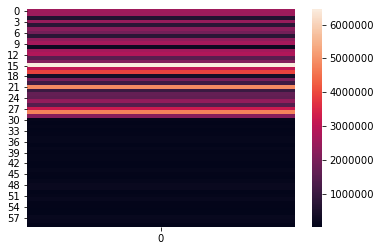

In [40]:
print(gradients_before_burnin[:(D)].mean())
print(gradients_before_burnin[(D):].mean())
sns.heatmap(gradients_before_burnin.clone().detach().cpu().numpy()[:, np.newaxis])


tensor(782452.1250, device='cuda:0')
tensor(6780.2192, device='cuda:0')


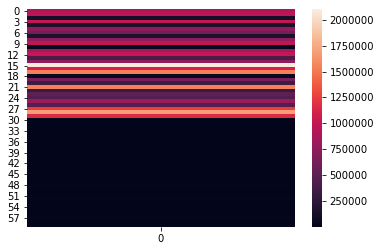

In [41]:
print(gradient_post_burn_in[:D].mean())
print(gradient_post_burn_in[D:].mean())
sns.heatmap(gradient_post_burn_in.clone().detach().cpu().numpy()[:, np.newaxis])

tensor(8054.7080, device='cuda:0')
tensor(3465.2913, device='cuda:0')


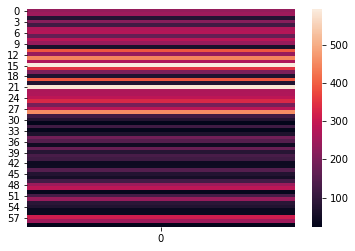

In [42]:
print(subset_indices_before_burnin[:D].sum())
print(subset_indices_before_burnin[D:].sum())
sns.heatmap(subset_indices_before_burnin.clone().detach().cpu().numpy()[:, np.newaxis])

tensor(2475.4834, device='cuda:0')
tensor(404.5166, device='cuda:0')


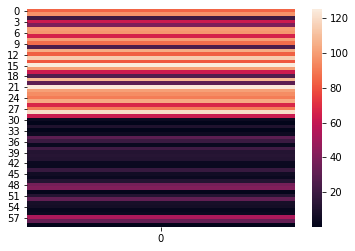

In [43]:
print(subset_indices_post_burnin[:D].sum())
print(subset_indices_post_burnin[D:].sum())
sns.heatmap(subset_indices_post_burnin.clone().detach().cpu().numpy()[:, np.newaxis])

In [44]:
subset_indices_post_burnin[:(D)]

tensor([ 84.1568,  96.9452,  20.1934,  63.0160,  39.4045, 100.1158,  98.5979,
         66.3731, 100.5784,  86.6653,  25.1872, 104.9650,  83.2189, 114.8164,
         80.9674, 125.1020, 100.4030,  62.7180,  26.7042, 107.8227,  30.0143,
        123.9289, 100.7276,  95.5401,  90.9234, 104.2425,  67.6549,  91.5436,
        120.1683,  62.7887], device='cuda:0')

In [45]:
subset_indices_post_burnin[(D):]

tensor([4.1238e+00, 8.1906e-04, 1.0744e+01, 1.1052e-01, 4.1047e+00, 2.9793e+01,
        1.9198e+01, 3.1139e+00, 2.1036e+01, 1.2121e+01, 1.2857e+01, 1.2118e+01,
        3.4539e+00, 3.0034e+00, 1.8314e+01, 5.4253e+00, 3.8314e+00, 1.2079e+01,
        3.7277e+01, 4.0618e+01, 1.1760e+00, 1.2165e+01, 3.1687e+01, 7.8009e+00,
        6.3710e+00, 2.1315e+00, 3.8615e+00, 5.2926e+01, 3.2683e+01, 3.9315e-01],
       device='cuda:0')

In [46]:
subset_indices_post_burnin[:(D)].sum() - subset_indices_post_burnin[(D):].sum()

tensor(2070.9668, device='cuda:0')

In [47]:
w = sample_subset(vae_gumbel_truncated.logit_enc, 
                  vae_gumbel_truncated.k, 
                  vae_gumbel_truncated.t).view(-1)
top_ind = torch.argsort(w, descending = True)[:vae_gumbel_truncated.k]

In [48]:
sum(top_ind < 30)

tensor(21, device='cuda:0')

In [49]:
sum(top_ind >= 30)

tensor(3, device='cuda:0')

In [50]:
sum(w > 0.5)

tensor(24, device='cuda:0')

In [51]:
w

tensor([1.8218e+00, 1.0117e+00, 9.6138e-01, 1.0001e+00, 1.2009e+00, 0.0000e+00,
        1.0007e+00, 0.0000e+00, 1.4812e-42, 7.2327e-01, 0.0000e+00, 1.1445e+00,
        1.4013e-45, 9.9930e-01, 5.5550e-01, 9.8462e-01, 1.0000e+00, 1.0009e+00,
        0.0000e+00, 9.6420e-01, 1.5550e-36, 1.0000e+00, 1.2234e-22, 1.0000e+00,
        0.0000e+00, 8.5234e-01, 9.8763e-01, 1.0331e+00, 1.0154e+00, 9.9471e-01,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 6.0418e-01, 0.0000e+00, 0.0000e+00, 1.6884e-17, 0.0000e+00,
        1.4763e-25, 0.0000e+00, 7.0270e-41, 0.0000e+00, 0.0000e+00, 2.6625e-44,
        7.4836e-11, 6.3923e-01, 0.0000e+00, 2.8867e-01, 7.9820e-01, 8.1770e-29,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 4.1769e-01, 0.0000e+00, 0.0000e+00],
       device='cuda:0')

In [52]:
w[w>0.5]

tensor([1.8218, 1.0117, 0.9614, 1.0001, 1.2009, 1.0007, 0.7233, 1.1445, 0.9993,
        0.5555, 0.9846, 1.0000, 1.0009, 0.9642, 1.0000, 1.0000, 0.8523, 0.9876,
        1.0331, 1.0154, 0.9947, 0.6042, 0.6392, 0.7982], device='cuda:0')

In [53]:
sum(w)

tensor(24.0000, device='cuda:0')

In [54]:
sum(w[top_ind])

tensor(23.2936, device='cuda:0')

In [55]:
w[top_ind]

tensor([1.8218, 1.2009, 1.1445, 1.0331, 1.0154, 1.0117, 1.0009, 1.0007, 1.0001,
        1.0000, 1.0000, 1.0000, 0.9993, 0.9947, 0.9876, 0.9846, 0.9642, 0.9614,
        0.8523, 0.7982, 0.7233, 0.6392, 0.6042, 0.5555], device='cuda:0')